#I. 뉴스 크롤링

### 0. 패키지 설치

In [ ]:
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 셀레니움 - 창 안 켜지게 옵션 설정
# 옵션 생성
options = webdriver.ChromeOptions()
# 창 숨기는 옵션 추가
options.add_argument("headless")
# driver = webdriver.Chrome(chrome_driver_dir, options=options)

### 1. 한 카테고리와 한 페이지에서 뉴스 기사 링크 수집

- 헤드라인 뉴스가 아닌, 실시간 최신순 뉴스(class="section_body") 수집
- 페이지당 기사 20개
- 경제 탭 고유번호 sid=101

In [ ]:
def extract_url(page=1, sid=101):
    ### 뉴스 분야(sid)와 페이지(page)를 입력하면 그에 대한 링크들을 리스트로 추출하는 함수 ###

    ## 1. url의 html 구조를 가져온댜
    url = f"https://news.naver.com/main/main.naver?mode=LSD&mid=shm&sid1={sid}#&date=%2000:00:00&page={page}"
    driver = webdriver.Chrome(options=options)  # for Mac
    driver.get(url)
    req = driver.page_source
    soup = BeautifulSoup(req, "html.parser")

    # 크롤링 대상 섹션 중에서 a태그가 있는 것을 고른다
    body_text = soup.find(name="div", attrs={"class":"section_body"}).find_all(name="a")

    ## 2. a태그의 href 속성을 리스트로 추출하여, 크롤링할 페이지 리스트를 생성 (모든 기사 링크 리스트)
    page_urls = []
    for index in body_text:
        if "href" in index.attrs:  # href가 있는 것만 고름
            if ( f"sid={sid}" in index["href"] # 경제
                and "article" in index["href"] # 기사인 것 (광고 등 제외)
               ):
                page_urls.append(index["href"])

    driver.close()
    return page_urls

In [ ]:
page_urls = extract_url(page=1, sid=101)
page_urls # 동일 뉴스의 이미지와 제목이 모두 수집되어 링크가 2개씩 중복 (이후 제거)

['https://n.news.naver.com/mnews/article/009/0005158983?sid=101',
 'https://n.news.naver.com/mnews/article/009/0005158983?sid=101',
 'https://n.news.naver.com/mnews/article/011/0004214460?sid=101',
 'https://n.news.naver.com/mnews/article/011/0004214460?sid=101',
 'https://n.news.naver.com/mnews/article/006/0000118938?sid=101',
 'https://n.news.naver.com/mnews/article/006/0000118938?sid=101',
 'https://n.news.naver.com/mnews/article/119/0002730880?sid=101',
 'https://n.news.naver.com/mnews/article/119/0002730880?sid=101',
 'https://n.news.naver.com/mnews/article/016/0002170166?sid=101',
 'https://n.news.naver.com/mnews/article/016/0002170166?sid=101',
 'https://n.news.naver.com/mnews/article/243/0000047543?sid=101',
 'https://n.news.naver.com/mnews/article/243/0000047543?sid=101',
 'https://n.news.naver.com/mnews/article/661/0000028584?sid=101',
 'https://n.news.naver.com/mnews/article/661/0000028584?sid=101',
 'https://n.news.naver.com/mnews/article/025/0003293997?sid=101',
 'https://

In [ ]:
# 처음과 마지막 기사만 확인
print(page_urls[0])
print(page_urls[-1])
print('중복 제거 전:', len(page_urls))

https://n.news.naver.com/mnews/article/009/0005158983?sid=101
https://n.news.naver.com/mnews/article/421/0006929958?sid=101
중복 제거 전: 40


In [ ]:
# 중복 url을 제거합니다.
page_urls = list(set(page_urls)) # 순서 고려하지 않으므로 위에서 확인한 링크와 다를 수 있음

# 다섯 개의 페이지(기사 5개)를 출력합니다.
for page in page_urls[:5]:
    print(page)

# 크롤링에 사용한 브라우저를 종료합니다.
# driver.close()
print('중복 제거 후:', len(page_urls))

https://n.news.naver.com/mnews/article/661/0000028584?sid=101
https://n.news.naver.com/mnews/article/119/0002730880?sid=101
https://n.news.naver.com/mnews/article/009/0005158941?sid=101
https://n.news.naver.com/mnews/article/277/0005286858?sid=101
https://n.news.naver.com/mnews/article/243/0000047540?sid=101
중복 제거 후: 20


### 2. 개별 기사 페이지 내 텍스트 구조와 크롤링 항목 확인

In [ ]:
# 샘플 페이지로 확인
driver = webdriver.Chrome(options=options)  # for Mac
sample1 = 'https://n.news.naver.com/mnews/article/009/0005158945?sid=101' #매일경제 하단 박스
sample2 = 'https://n.news.naver.com/mnews/article/243/0000047521?sid=101' #고릴라 카드 기사
driver.get(sample2) # OR driver.get(page_urls[6])
req = driver.page_source
soup = BeautifulSoup(req, 'html.parser')

# 제목
title_area = soup.find(name="div", attrs={"class":"media_end_head_title"})
title = title_area.find_all('h2')[0]

# 본문
content_paragraphs = soup.find(name="div", attrs={"class":"newsct_article"}) # "newsct_article _article_body"

# 본문 - 사진 캡션 제거
captions_list = content_paragraphs.findAll(name="span", attrs={"class":"end_photo_org"})
for caption in captions_list:
    caption.decompose()

# 본문 - 전처리
'''
문장 부호가 없어 구분되지 않는 문장들 사이에 공백 추가하여
1. 요약문 한 줄 마지막 단어와 다음 줄 첫 단어가 이어지지 않도록
2. 소제목 마지막 단어와 본문 첫 단어가 이어지지 않도록
'''
content_corpus = content_paragraphs.get_text(separator=" ").strip() # 텍스트만

# 날짜
date_html = soup.find(name="span", attrs={"class":"media_end_head_info_datestamp_time _ARTICLE_DATE_TIME"}) # 최초 입력 기준, 수정 시각 무시
date = date_html.attrs["data-date-time"]

# 언론사
press_logo = soup.find(name="img", attrs={"class":"media_end_head_top_logo_img"})
press = press_logo.attrs["alt"]

print(title.text)
print(date)
print(press)
print('---')
print(content_corpus)

# 크롤링에 사용한 브라우저를 종료합니다.
driver.close()

<div class="go_trans _article_content" id="dic_area">
<strong class="media_end_summary">고승훈 카드고릴라 대표 “언론에도 인사이트 줄 것”<br/>이용 금액 적다면 할인 카드…많다면 포인트·마일리지 추천<br/>카드커버 브랜드 ‘고스티’ 협업 확대…내년엔 해외진출 목표</strong>[이코노미스트 윤형준 기자] <strong>“원래부터 생각한 그림은 카드고릴라가 ‘카드 전문 미디어’가 되는 것입니다. 단순 비교·추천 플랫폼을 넘어서 정말 믿고 볼 수 있을 만한 콘텐츠를 제공해야 소비자들의 신뢰가 올라가죠.”</strong><br/><br/>국내 유일의 신용카드 비교 플랫폼 카드고릴라가 세상에 태어난 지 14년이 됐다. 개인(個人)이면 중학교 1학년에 해당하는 나이다. ‘이코노미스트’와 만난 고승훈 카드고릴라 대표는 자신을 ‘고인물’(한 집단에 오래 속한 사람)이라 칭하며 스스로를 낮췄다.<br/><br/>하지만 신용카드 콘텐츠를 향한 그의 애정은 여전히 ‘흐르는 물’이다. 고 대표는 “카드에 대한 모든 이야기를 담는 것이 우리의 가장 큰 DNA”라며 “에디터들을 지속 보강하고 있다”고 말했다. 지금도 에디터를 뽑을 때 언론사 못지 않게 기본적인 글쓰기 실력을 보고 있다. 나아가 그는 에디터들에게 변화하는 카드 시장에 대한 인사이트(통찰력)를 줄 수 있는 콘텐츠를 주문하고 있다.<br/><br/>고 대표는 이런 콘텐츠를 바탕으로 카드고릴라가 소비자와 언론, 그리고 카드사의 가교 역할을 하겠다는 의지를 나타냈다. 정말 업계의 고인물보다는 꿈과 체력이 넘치는 중학생에 가까웠다. 카드에 미쳐있는 그에게 카드 시장 트렌드와 카드고릴라의 미래에 대해 들어봤다. <br/><br/><strong>Q. 카드고릴라가 14살이 됐다. 최근 성적표는 어떤가.</strong><br/><br/>A. 최근 월간활성이용자수(MAU)가 100만명 정도 된다. 초창기보다 상당히 많이 증가했다. 누적으로는 3000만명이 넘었

### 3. 링크 리스트 내 모든 기사의 제목, 본문, 날짜, 언론사 정보 수집

In [ ]:
# 가지고 있는 모든 기사 링크의 '제목', '본문', '날짜', '언론사' 정보를 데이터 프레임으로 만듭니다.
def news_crawler(page_urls):
    # 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비합니다.
    columns = ["date", "title", "content", "press", "link"]
    df = pd.DataFrame(columns=columns)

    for page_url in tqdm(page_urls):

        # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
        driver = webdriver.Chrome(options=options)  # for Mac
        driver.get(page_url)
        req = driver.page_source
        soup = BeautifulSoup(req, "html.parser")

        # 제목
        title_area = soup.find(name="div", attrs={"class":"media_end_head_title"})
        title = title_area.find_all('h2')[0]

        # 제목 - 전처리; 제목 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
        if title is not None:
            row_title = title.text.replace("\n", " ")
        else:
            row_title = ""

        # 본문
        content_paragraphs = soup.find(name="div", attrs={"class":"newsct_article"}) # "newsct_article _article_body"

        # 본문 - 사진 캡션 제거
        captions_list = content_paragraphs.findAll(name="span", attrs={"class":"end_photo_org"})
        for caption in captions_list:
            caption.decompose()

        # 본문 - 문장 구분
        '''
        1. 문장 부호가 없어 구분되지 않는 문장들 사이에 공백 추가하여
        요약문 한 줄 마지막 단어와 다음 줄 첫 단어가 이어지지 않도록
        & 소제목 마지막 단어와 본문 첫 단어가 이어지지 않도록
        2. strip()으로 본문 시작과 끝에 있는 줄바꿈과 공백을 제거
        '''
        content_corpus = content_paragraphs.get_text(separator=" ").strip() # 텍스트만
        content_corpus = content_corpus.strip()

        # 날짜
        date_html = soup.find(name="span", attrs={"class":"media_end_head_info_datestamp_time _ARTICLE_DATE_TIME"}) # 최초 입력 기준, 수정 시각 무시
        date = date_html.attrs["data-date-time"]

        # 언론사
        press_logo = soup.find(name="img", attrs={"class":"media_end_head_top_logo_img"})
        press = press_logo.attrs["alt"]

        # 모든 정보를 하나의 데이터 프레임에 저장합니다.
        row = [date, row_title, content_corpus, press, page_url]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)

        # 크롤링에 사용한 브라우저를 종료합니다.
        driver.close()

    return df

In [ ]:
df = news_crawler(page_urls)
df.shape

  0%|          | 0/20 [00:00<?, ?it/s]

(20, 4)

In [ ]:
df

,title,content,date,press
0,"한 집에 한 대가 안돼, 차댈 곳 없어 ‘뱅뱅’.. “임대 살아서?”",1가구당 고작 0.79대 주차.. 비용 때문 분양 0.68대~1.28대↔임대 0.2...,2023-07-15 16:22:01,JIBS
1,"[데일리안 오늘뉴스 종합] 尹대통령, 우크라이나 깜짝 방문...젤렌스키와 정상회담,...","[데일리안 = 정진주 기자] ▲ 尹대통령, 우크라이나 깜짝 방문...젤렌스키와 정...",2023-07-15 17:53:01,데일리안
2,“최선 차선 모두 잘못됐네”…붕괴 사고로 머리 아픈 조합원들,아이파크 붕괴사고 후 GS건설로 시공사 변경했더니 조합 “집값 하락·단지 안전 ...,2023-07-15 13:11:01,매일경제
3,“한 집에 한 대도 못 대”…임대아파트 주차난 어쩌나,가구당 평균 주차가능대수 0.79대에 불과 결국 비용 문제…주차공간 늘리면 마진 줄...,2023-07-15 14:11:01,아시아경제
4,용진이형도 맛 본 새우깡 동생 ‘먹태깡’… 중고거래서 대박난 까닭,"먹태깡 품귀현상, 중고마켓에서 2~3배 웃돈 거래까지 1회당 4봉지 제한…식품업계 ...",2023-07-15 14:18:01,이코노미스트
5,“미국은 이미 중국에 졌다”...美포드 회장 작심한 듯 ‘전기차 미래’ 쏟아냈다 [...,"美포드 회장, 인터뷰에서 작심발언 ‘중국이 미래차 시장 재편할 것’ 전망 비야디,...",2023-07-15 13:37:01,매일경제
6,웃돈만 9억인데 사라진 아파트…한남3구역 현금청산 날벼락[부동산360],한남3구역 현금청산자 216명…20명 중 1명 꼴 일부는 소송전에도 나서 투기과열지...,2023-07-15 17:42:01,헤럴드경제
7,'영끌' 오픈런 명품소비 1위 한국…이부진도 블핑도 루이비통家와 각별한 관계로?,"CNBC ""작년 한국인 명품 구매액 세계 1위"" 루이비통 셋쨰 며느리 구이엇 이부진...",2023-07-15 18:11:01,서울경제
8,오바마의 첫 알바가 이 곳에서? 무더위 속 그가 얻은 교훈 [추동훈의 흥부전],"[브랜드로 남은 창업자들-09] 배스킨 라빈스 #미국의 첫 흑인 대통령, 버락 오바...",2023-07-15 18:26:00,매일경제
9,어떻게 빨려들어갈지 모르는 민감정보 '블랙홀' 챗GPT 규제책은,[인공지능의 두 얼굴(17)] 개발 및 이용 과정에서 이용자 정보 대량 학습·유출...,2023-07-15 18:06:01,미디어오늘


### 4. 원하는 페이지 번호까지 모든 기사 "링크" 수집해 page_urls_all 만들기
- 1에서 만든 `extract_url` 활용

In [ ]:
def re_extract_url(first_page, last_page, sid=101):
    ### 원하는 분야, 원하는 페이지의 뉴스 링크를 수집하여 중복 제거한 리스트로 변환하는 함수 ###
    page_urls_all = []
    for i in tqdm(range(first_page, last_page)):
        lst = extract_url(page=i, sid=101)
        page_urls_all.extend(lst)

    # 중복 제거
    page_urls_all = list(set(page_urls_all))

    return page_urls_all

2. 학습 데이터: 07.10(월)~07.13(목) 06시까지 → Fine Tuning
3. 검증 데이터: 07.13(목) 06시부터 07.14(금) 06시까지 (뉴스레터)

53-134

In [ ]:
first_page = int(input('첫 페이지 번호를 입력하세요: '))
last_page = int(input('마지막 페이지 번호를 입력하세요: '))+1

page_urls_all = re_extract_url(first_page, last_page, sid=101)
print(len(page_urls_all))

첫 페이지 번호를 입력하세요: 53
마지막 페이지 번호를 입력하세요: 134


  0%|          | 0/82 [00:00<?, ?it/s]

1636


### 5. page_urls_all 에 담긴 모든 기사의 제목, 본문, 날짜, 언론사 + 링크를 리스트로 만들기
- 3과 동일한 함수 사용

In [ ]:
df_fin = news_crawler(page_urls_all)

  0%|          | 0/1636 [00:00<?, ?it/s]

In [ ]:
df_fin.shape

(1636, 5)

In [ ]:
# 최신순 정렬
df_fin = df_fin.sort_values('date', ascending=True)
df_fin = df_fin.reset_index(drop=True)

# 기간 아닌 것 삭제, 둘째날 6시 전까지
df_fin = df_fin.iloc[22:1617].reset_index(drop=True)
df_fin

,date,title,content,press,link
0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...
1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...
2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...
3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...
...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,머니S,https://n.news.naver.com/mnews/article/417/000...
1570,2023-07-14 05:46:01,"""어쩌다 이렇게까지"" 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자…수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,아이뉴스24,https://n.news.naver.com/mnews/article/031/000...
1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승...엔비디아 4.7%↑",[파이낸셜뉴스] 뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...


In [ ]:
import openpyxl
date = input('크롤링 기간을 입력하세요(07XX-07XX 형식): ')
df_fin.to_excel(f'news_{date}.xlsx') # 저장
pd.read_excel(f'news_{date}.xlsx', index_col=0) # 확인

크롤링 기간을 입력하세요(07XX-07XX 형식): 0713-0714


,date,title,content,press,link
0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...
1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...
2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...
3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...
...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,머니S,https://n.news.naver.com/mnews/article/417/000...
1570,2023-07-14 05:46:01,"""어쩌다 이렇게까지"" 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자…수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,아이뉴스24,https://n.news.naver.com/mnews/article/031/000...
1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승...엔비디아 4.7%↑",[파이낸셜뉴스] 뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...


# II. 전처리

In [ ]:
import requests
# from selenium import webdriver
# from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
import pandas as pd
import numpy as np

# 한자
# !pip install hanja
import hanja

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel('news_0713-0714.xlsx', index_col=0)
df

,date,title,content,press,link
0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...
1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...
2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...
3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...
...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,머니S,https://n.news.naver.com/mnews/article/417/000...
1570,2023-07-14 05:46:01,"""어쩌다 이렇게까지"" 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자…수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,아이뉴스24,https://n.news.naver.com/mnews/article/031/000...
1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승...엔비디아 4.7%↑",[파이낸셜뉴스] 뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...


In [ ]:
print(df.loc[1435, 'link'])
print(df.loc[1435, 'content'])

https://n.news.naver.com/mnews/article/008/0004911893?sid=101
인플레이션 압박 다시 커질 수도…"공급망 안정까지 최소 3개월" 인도 경제가 계절풍 '몬순'에 흔들리고 있다. 몬순이 몰고 온 기록한 폭우로 인한 홍수 피해로 필수 식자재 가격이 폭등하는 등 물가상승률(인플레이션) 압박이 다시 높아지고 있기 때문. 12일(현지시간) CNBC 등 주요 외신은 인도의 토마토 가격이 전년 대비 300% 이상 폭등했다며 "인도 토마토가 기상이변으로 위기에 직면했다"고 보도했다. CNBC에 따르면 11일 기준 인도의 토마토 가격은 1kg당 108.92루피(약 1686원)로, 전년 동기 대비 341% 급등했다. 인도 농업 연구 전문 협의체인 국립생물스트레스연구소는 "안드라프라데시, 마하라슈트라, 카르나타카 등 주요 토마토 생산지에서 발생한 홍수가 이번 가격 급등의 주요 원인"이라고 분석했다. 연구소는 "이들 주(토마토 생산지)의 과도한 강우량으로 인해 토마토 작물이 큰 영향을 받았다. 폭우와 홍수로 인해 토마토 작물의 상당 부분이 파괴됐다"고 설명했다. 인도 기상청에 따르면 지난 6~7월 평균 강수량의 10배 이상에 달했다.  인도는 세계에서 두 번째로 큰 토마토 생산국이다. 인도에서 토마토는 양파와 함께 인도 소비자의 일상생활에 '절대적인 필수품'으로, 토마토 가격 상승은 인도 물가 나아가 국가 경제에도 영향을 줄 수 있다. 인도의 농업은 전체 국내총생산(GDP)의 30%를 차지한다.  지난 5월 인도의 소비자물가지수(CPI)는 전년 동월 대비 4.25% 올랐다. 이는 2021년 1월 이후 2년 4개월 만에 가장 낮은 수준으로, 인도의 물가 상승세가 안정화되고 있었다. 하지만 6~7월 인도를 강타한 폭우로 홍수 피해가 커지면서 인플레이션 우려가 다시 커졌다. 인도 정부 발표에 따르면 6월 CPI는 전년 동월 대비 4.81% 상승해, 블룸버그가 집계한 전문가 예상치 4.6%를 웃돌았다. 특히 식음료 물가상승률은 지난 5월의 3.

## 특수문자 종류 확인

In [ ]:
# 한글 영어 숫자 마침표 제외하고 특수문자만 남기기
def special_character(text):
    text = hanja.translate(text, 'substitution') # 한자 -> 한글
    pattern_special = r'[가-힣0-9a-zA-Z\.\(\),\"\'\s]' # 한글, 숫자, 영어 등 제거
    text = re.sub(pattern_special, '', text)
    return text

content_special = df['content'].apply(lambda s: special_character(s))
title_special = df['title'].apply(lambda s: special_character(s))

char = content_special.values.flatten().tolist() + title_special.values.flatten().tolist()
char = list("".join(char))
char_unique = list(set(char)) # 중복 제거
print(" ".join(char_unique))
from collections import Counter
Counter(char).most_common() # 빈도 높은순

% ™ ” ㎝ ë ～ … ▷ Ⅲ ⑨ ∙ · ᆞ & ︎ ~ ㎐ ㎾ ‘ ] 年 ㅇ ㆍ $ ※ ↑ ⓒ △ ㎞ ・ ! ･ • ⑤ ℓ ▲ ◀ 】 〉 ㎥ ］ ’ ⋅ ㎢ ↓ ● × ㈜ ㎜ ＆ │ - ; 【 _ ㄹ * ▶ ｜ “ ＃ ◆ ☎ : / # ‥ ℃ ① ― ⑧ ○ + ③ · ㎎ ? 「 α = ㏗ – ☞ ▣ ㎖ ㎠ | ^ ▽ → ô ｍ ⓰ é ◐ ■ [ ` □ 李 ％ ‧ ◎ ◇ 」 ㎏ > ｇ @ ∼ ④ < ② ． ㎉ ━ ․ ′ ㎡


[('%', 8356),
 ('·', 4515),
 ('“', 3188),
 ('”', 3156),
 ('‘', 2362),
 ('’', 2345),
 ('-', 1712),
 ('…', 1569),
 ('~', 1053),
 ('[', 1051),
 (']', 1051),
 ('=', 718),
 ('/', 619),
 ('△', 566),
 ('?', 553),
 (':', 507),
 ('㎡', 402),
 ('▲', 340),
 ('&', 260),
 ('→', 256),
 ('▷', 210),
 ('@', 173),
 ('>', 158),
 ('∼', 141),
 ('+', 138),
 ('↑', 136),
 ('━', 124),
 ('<', 118),
 ('#', 116),
 ('㎜', 113),
 ('▶', 98),
 ('■', 75),
 ('㎞', 69),
 ('◆', 68),
 ('!', 66),
 ('↓', 65),
 ('◇', 57),
 ('`', 48),
 ('㎏', 41),
 ('‧', 39),
 ('※', 30),
 ('□', 30),
 ('㈜', 29),
 ('．', 27),
 ('㎖', 25),
 ('▣', 25),
 ('【', 24),
 ('】', 24),
 ('○', 24),
 ('*', 21),
 ('●', 21),
 ('―', 20),
 ('☞', 18),
 ('ㆍ', 15),
 ('_', 14),
 ('㎾', 14),
 ('·', 14),
 ('㎐', 14),
 ('×', 12),
 ('℃', 11),
 ('①', 10),
 ('②', 10),
 ('◐', 10),
 ('㎉', 9),
 ('・', 8),
 ('〉', 8),
 ('③', 7),
 ('ℓ', 7),
 ('ⓒ', 7),
 ('％', 7),
 ('‥', 7),
 ('–', 6),
 ('∙', 6),
 ('㎝', 6),
 ('◀', 6),
 ('･', 5),
 ('⋅', 5),
 ('•', 5),
 ('′', 4),
 ('「', 4),
 ('」', 4),
 ('㎎'

## TBD
- 경제 기사답게 퍼센트(%, ％)가 가장 많이 등장 -> 단위 통일
- △▲ 등은 소제목(또는 나열된 항목), ↑↓ 는 상승, 하락을 의미할 것으로 보임 -> 상승(증가), 하락(감소)으로 대체할 것인지? 문맥 따라 다른데...
    - 금리 인상, 시가총액 증가 등등
- ㎡ ㎥ ㎞ ㎏ ㎖ ㎾ ㎐ ℃ ㎉ ℓ ㎝ ㎎ ㎠ ㎢ ㏗ $ ｍ ｇ 등 단위도 자주 사용됨 -> 특수문자를 영어로 대체해 동의어 mapping (선택사항)
- 年 李 : 한글로 변환되지 않은 한자도 보임 -> 수작업


추가로
- () 안 문자 제거할 것인지?


- 주식 종목, 기업명 사전 만들거나 ... 예외 처리

### nltk로 ↑↓가 쓰인 맥락을 살펴보자

In [ ]:
char = '↑'
# char = '↓'

for num, sent in tqdm(enumerate(df['title'])):
    # 단어 좌우 00문자
    con_list = sent.concordance_list(char, width=20, lines=10) # 좌우 20문자, 최대 10개
    if con_list == []:
        pass
    else:
        print(num, con_list['line'])

'''마지막줄 수정한 코드는 안 돌려봄'''

0it [00:00, ?it/s]

25 [ConcordanceLine(left=['올라', '…', '성수', '는', '40억원'], query='↑', right=[], offset=10, left_print='수 는 40억원', right_print='', line='수 는 40억원 ↑ ')]
65 [ConcordanceLine(left=['만에', '최소', '…', '나스닥', '1.15%'], query='↑', right=['[', '뉴욕증시', '브리핑', ']'], offset=8, left_print='스닥 1.15%', right_print='[ 뉴욕증시 브', line='스닥 1.15% ↑ [ 뉴욕증시 브')]
87 [ConcordanceLine(left=[']', '미', '6월', 'CPI', '3.0%'], query='↑', right=['…', '인플레', '둔화', '세'], offset=8, left_print='CPI 3.0%', right_print='… 인플레 둔화', line='CPI 3.0% ↑ … 인플레 둔화')]
99 [ConcordanceLine(left=['땡큐', '..', '목표', '주가', '13%'], query='↑', right=['-', '한', '투'], offset=12, left_print='표 주가 13%', right_print='- 한 투', line='표 주가 13% ↑ - 한 투')]
113 [ConcordanceLine(left=['상승', '마감', '…', '애플', '0.90%'], query='↑', right=['·', '테슬라', '0.82%', '↑'], offset=11, left_print='애플 0.90%', right_print='· 테슬라 0.', line='애플 0.90% ↑ · 테슬라 0.'), ConcordanceLine(left=['0.90%', '↑', '·', '테슬라', '0.82%'], query='↑', right=[], offset=15, left_print='슬라 0.82%

## 불필요한 텍스트 제거
#### 마지막에 코드 하나로 통합할 때: [단독] 제거를 여기에서 하자

In [ ]:
def preprocess(text):

    '''기사 형식'''
    # 바이라인: 이메일, url 제거
    import re
    pattern_mail = re.compile(r'[\w.+]+\s?@\s?[\w]+\.[\w.]+') # 공백 포함: mbcjebo @ mbc.co.kr
#     pattern_mail = re.compile(r'([a-zA-Z0-9._%+-]+@[a-zA-Z0-9-]+(\.[a-zA-Z0-9-.])+')
#     pattern_mail = re.compile(r'[a-zA-Z0-9+-_.]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', flags=re.IGNORECASE) # .com .co.kr 등
    text = re.sub(pattern_mail, '', text)
    pattern_url = re.compile(r'(?:https?:\/\/)+?[-_0-9a-z]+(?:[\.\/][-_0-9a-z]+)*', flags=re.IGNORECASE)
    text = re.sub(pattern_url, '', text)
    pattern_call = re.compile(r'\d{2,3}-\d{3,4}-\d{4}')
    text = re.sub(pattern_call, '', text)

#     text = text.replace('기자 단독', '')
#     text = text.replace('[단독]', '')

    '''특수문자'''
    # 한자를 한글로 치환 (兆, 조)
    text = text.replace('比', '대비')
    text = hanja.translate(text, 'substitution')
    text = text.replace('年', '년')
    text = text.replace('李', '이') # 이창용 한은 총재

    # 단위 치환
    text = text.replace('㎞', 'km')
    text = text.replace('㎏', 'kg')
    text = text.replace('㎖', 'ml')
    text = text.replace('㎎', 'mg')
    text = text.replace('ℓ', 'l')
    text = text.replace('㎝', 'cm')
    text = text.replace('㏗', 'pH')
    text = text.replace('$', '달러')
    text = text.replace('ｍ', 'm')
    text = text.replace('ｇ', 'g')
    text = text.replace('㎾', 'kW')
    text = text.replace('㎐', 'Hz') # 헤르츠도 있음 - 동의어 사전 필요함
    text = text.replace('℃', '섭씨')
    text = text.replace('㎉', '칼로리')
    text = text.replace('％', '%')
    text = text.replace('%', '퍼센트')
    text = text.replace('...', '…') # 추후 띄어쓰기 위함

    # 특수문자 해석
    # 주가 상승, 인구 이동 증가 등등 문맥에 맞게 변환해야 함. 해결방법???
#     text = text.replace('↑', ' 상승')
#     text = text.replace('↓', ' 하락')

    # 특수문자 제거
    # 예외: .(1.2%), &(B&S 홀딩스, S&P), ~(30~40)
    pattern_special = r'[^가-힣0-9a-zA-Z\.,\%\&\~\s]' # 한글, 숫자, 영어, 공백, 기타 문자만 유지
    text = re.sub(pattern_special, ' ', text)

    # [], (), {}, <> 괄호와 괄호 안 문자 제거하기
#( ) 괄호 안에 1문자 이상 있으면 제거
#     pattern = r'\([^)]*\)'  # () # ('\(.+?\)', '')
#     s = re.sub(pattern=pattern, repl='', string=s)

    # 예외: 숫자 (4.5조, 4.5%, 3.75%, 90% ...)
#     TBD
#     text = re.sub('[-=+,#\/\?:^\.@*\"※~ㆍ!』|\(\)\[\]`\'…》\”\“\‘\’·▷▶▲ⓒ◆■]', ' ', text) # 이 중 하나와 매치
#     text = re.sub('[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]', ' ', text)

    # 다중 공백 제거
    text = ' '.join(text.split()) # 공백 기준으로 분리 후 단어 사이에 공백 삽입
    return text

In [ ]:
# 전처리
df['title_p'] = df['title'].apply(lambda s: preprocess(s))
df['content_p'] = df['content'].apply(lambda s: preprocess(s))

# 텍스트 길이 계산
df['len'] = df['content_p'].apply(len)
df.sort_values(by=['len'])

,date,title,content,press,link,title_p,content_p,len
259,2023-07-13 09:18:03,파라다이스시티 부티크 호텔 '아트파라디소' 3년 만에 재개장,(서울=연합뉴스) 차민지 기자 = 파라다이스시티는 부티크 호텔 '아트파라디소'를 새...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...,파라다이스시티 부티크 호텔 아트파라디소 3년 만에 재개장,서울 연합뉴스 차민지 기자 파라다이스시티는 부티크 호텔 아트파라디소 를 새로 단장하...,263
268,2023-07-13 09:20:59,"나노엔텍, 에이플러스그룹 시너지 기대감..↑",에이플러스그룹 품에 안긴 나노엔텍이 강세다. 13일 오전 9시19분 나노엔텍은 전...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,"나노엔텍, 에이플러스그룹 시너지 기대감..",에이플러스그룹 품에 안긴 나노엔텍이 강세다. 13일 오전 9시19분 나노엔텍은 전일...,291
297,2023-07-13 09:29:10,"이마트24, '라떼는쑥파르페' 출시…""할매니얼 저격""",컵 타입 파르페…투 플러스 원 행사 [서울=뉴시스] 심동준 기자 = 이마트24는 자...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,"이마트24, 라떼는쑥파르페 출시 할매니얼 저격",컵 타입 파르페 투 플러스 원 행사 서울 뉴시스 심동준 기자 이마트24는 자체 브랜...,294
520,2023-07-13 10:36:41,"서대문구, 홍제1구역 '서대문푸르지오센트럴파크' 준공 인가",(서울=뉴스1) 김도엽 기자 = 서울 서대문구는 '서대문푸르지오센트럴파크' 아파트가...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,"서대문구, 홍제1구역 서대문푸르지오센트럴파크 준공 인가",서울 뉴스1 김도엽 기자 서울 서대문구는 서대문푸르지오센트럴파크 아파트가 들어선 홍...,305
359,2023-07-13 09:51:35,"최태원 ""전 세계 블록화로 기업 살아남기 어려워‥정부·민간 함께 뛰어야""","최태원 대한상공회의소 회장이 최근 경제 상황에 대해 ""미·중 갈등으로 전 세계 블록...",MBC,https://n.news.naver.com/mnews/article/214/000...,최태원 전 세계 블록화로 기업 살아남기 어려워 정부 민간 함께 뛰어야,최태원 대한상공회의소 회장이 최근 경제 상황에 대해 미 중 갈등으로 전 세계 블록화...,346
...,...,...,...,...,...,...,...,...
1031,2023-07-13 14:56:05,한은 총재 “물가·미국 금리·가계부채는 금리 인상 옵션”[일문일답],“모든 금통위원 3.75% 가능성 열어놔” “자금시장 크게 우려하지 않아…안정적인 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,한은 총재 물가 미국 금리 가계부채는 금리 인상 옵션 일문일답,모든 금통위원 3.75퍼센트 가능성 열어놔 자금시장 크게 우려하지 않아 안정적인 상...,7458
736,2023-07-13 11:43:19,[출발 서해안 시대] 현대삼호중 “친환경선박 제조기술 1위…3년 6개월 일감 확보”,[KBS 목포] ■ 인터뷰 자료의 저작권은 KBS에 있습니다. 인용보...,KBS,https://n.news.naver.com/mnews/article/056/001...,출발 서해안 시대 현대삼호중 친환경선박 제조기술 1위 3년 6개월 일감 확보,KBS 목포 인터뷰 자료의 저작권은 KBS에 있습니다. 인용보도 시 출처를 밝혀주시...,7916
890,2023-07-13 13:53:01,"이창용 ""가계부채 우려된다…GDP 대비 비율, 우리경제 큰 불안 요소""[일문일답]","이창용 한은 총재, 7월 금통위 기자간담회 ""GDP 대비 가계부채 작년 106%에서...",이데일리,https://n.news.naver.com/mnews/article/018/000...,"이창용 가계부채 우려된다 GDP 대비 비율, 우리경제 큰 불안 요소 일문일답","이창용 한은 총재, 7월 금통위 기자간담회 GDP 대비 가계부채 작년 106퍼센트에...",8386
1046,2023-07-13 15:02:07,사모펀드들은 어떻게 흙속의 진주를 발견하나 [김태엽의 PEF썰전],[한경 CFO Insight] 김태엽 어펄마캐피탈 한국대표 taeyub.kim@af...,한국경제,https://n.news.naver.com/mnews/article/015/000...,사모펀드들은 어떻게 흙속의 진주를 발견하나 김태엽의 PEF썰전,한경 CFO Insight 김태엽 어펄마캐피탈 한국대표 이 기사는 07월 12일 1...,9278


In [ ]:
# 언론사 개수
pressdf = pd.DataFrame(df['press'].value_counts().iteritems(), columns=['press', 'cnt'])
pressdf

,press,cnt
0,헤럴드경제,104
1,머니투데이,97
2,이데일리,92
3,매일경제,89
4,파이낸셜뉴스,86
...,...,...
57,코메디닷컴,2
58,주간경향,1
59,여성신문,1
60,채널A,1


In [ ]:
import openpyxl
pressdf.to_excel('전체언론사_빈도수_0804_홍주.xlsx') # 저장
pd.read_excel('전체언론사_빈도수_0804_홍주.xlsx', index_col=0) # 확인

,press,cnt
0,헤럴드경제,104
1,머니투데이,97
2,이데일리,92
3,매일경제,89
4,파이낸셜뉴스,86
...,...,...
57,코메디닷컴,2
58,주간경향,1
59,여성신문,1
60,채널A,1


In [ ]:
df.press.describe()

count      1573
unique       62
top       헤럴드경제
freq        104
Name: press, dtype: object

In [ ]:
df['len'].describe()

count     1573.000000
mean      1490.944692
std        822.665801
min        263.000000
25%        978.000000
50%       1337.000000
75%       1804.000000
max      12844.000000
Name: len, dtype: float64

In [ ]:
# 제목 확인용

for num, content in enumerate(df['title_p']):
    print(num, content[:70], '\n')

0 차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발 

1 단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신 

2 전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여 

3 마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위 

4 일주일 만에 두 배 뛴 금양 시장서는 이게 맞아 

5 유상증자 이후 쥐꼬리 무증 에 냉가슴 앓는 개미들 

6 뉴욕마감 나스닥 1퍼센트 안도 랠리 CPI 3퍼센트에 약해진 금리 압박 

7 온 가족 돈 당긴 20억 코인 한달째 묶여 매일 약 먹고 잠 든다 

8 물가가 Fed 사정권에 들어왔다 증시에 새 추동력 뉴욕마감 

9 아파트 거래 입주 물량 증가 은행권 주담대 한달 새 7조 급증 

10 뜨거운 쇳덩이가 차강판 되기까지 기아 광주 포스코 광양공장 현장 

11 삼성 KB도 출사표 돌 넘긴 카카오페이손보, 교보에 SOS 

12 기로의상장사 유니켐 경영권 분쟁 2라운드 앞두고 치열한 지분 경쟁 

13 등급하향 기조인데 나홀로 상향 우위 인 나신평, 이유는 

14 인생3막 기업 어르신 식사에 콧줄 은 그만 젤리식 쌀식품 개발 복지유니온 

15 불법사채의 덫 대부업서 사라진 150만명, 어디로 갔나 

16 뉴욕증시 금리 인상기 끝난다 vs 근원물가 아직 높다 

17 불법사채의 덫 저신용자 구해야 합법 대부업 몰락 막을 방법은 

18 뉴욕 증시 상승 마감 물가 상승률 3퍼센트 환호 

19 흑자 전환, 언제 하나 캐롯 신한EZ손보의 현주소 

20 그렇게 열심히 일했는데 톱10 탈락한 한국경제, 이유 알고보니 

21 마켓인 돈줄 막힌 PF시장 차환 난항에 높아지는 디폴트 우려 

22 물타기 하다 덜컥 2대 주주된 모험가좌 주주활동 나선다 

23 공정위 조직개편 핵심 조사관리관 3개월 만에 공석 후임은 

24 어렵다 어려워 디지털 보험사, 실적 반등 가능할까 

25 압구정 아파트 2년새 11억 올라 성수는 40억원 

26 미 금리인상, 시장은 이번이 마지막 연준은 글쎄 글로

450 한은 동결로 한미 금리차 2퍼센트p 눈앞 자금유출 환율상승 압력 

451 AI 신약개발사 리커전 , 엔비디아 투자 소식에 80퍼센트 폭등 

452 공공기관도 당했다 창업진흥원, 1.8억 피싱 사기 

453 삼성전자, 미브로드컴에 시가총액 잡혀 반도체 4위로 

454 창진원, 정부기관 첫 피싱사기 당했다 1억7500만원 날릴 처지 

455 미 물가둔화에 7월 마지막 금리인상 솔솔 더 갈것 신중론도 종합 

456 노랑풍선, 2분기 패키지 상품 예약률 전년 대비 1200퍼센트 증가 

457 정년까지 일할 수 있을까 40대의 30퍼센트만 긍정 

458 미래에셋운용, TIGER2차전지소재Fn ETF 신규 상장 

459 5월 서울 빌딩 거래량 반등 일등공신은 꼬마빌딩 

460 한 대만 이중과세 방지법 시행 눈앞 반도체 기업 세부담 

461 합리적 분양가 춘천 레이크시티 아이파크 공급 

462 금호건설, 부산에코델타시티에 어울림 선봬 

463 토큰증권 법제화 시동 이달 중 법안 발의 

464 삼성자산운용, 삼성달러표시MMF법인 제1호 펀드 출시 

465 주가동향 진원생명과학, 핵산 기반 단클론 항체 플랫폼 신약 추진 소식에 주가 급등 

466 외국인도 반할 K안주 제주에 가면 특별한 맛이 있다 

467 스레드 굴욕 머스크, AI로 설욕 노린다 챗GPT 대항마 xAI 출범 

468 SK하이닉스, 전국 교고서 반도체 hy 스쿨 진행 

469 신동원 농심 회장 취임 2주년 2030년 미 라면시장 1위 목표 

470 한은, 연 3.5퍼센트 기준금리 4회 연속 동결 물가 둔화세 뚜렷 

471 미 인플레 전쟁서 승리 이달 금리 인상이 마지막 기대감 

472 국토교통부, 예타노선과 대안노선의 교통량 분석을 동일한 조건에서 객관적으로 분석했다 

473 한화 건설부문, 포레나 인천학익 8월 분양 

474 삼성전자, 초대형TV 선호 트렌드 맞춰 98형 신모델 출시 

475 강스템바이오텍, 아토피 줄기세포 치료제 임상3상 투약 300명 달성


824 데이터센터 요양시설 뜬다 하반기 상업용 부동산 6대 이슈는 

825 네 차례 연속 기준금리 3.5퍼센트로 동결 가상기자 뉴스픽 

826 셀트리온 3형제 합병 시동 검토 진행 중 시기 방법 미확정 

827 이창용 금통위원 전원, 기준금리 3.75퍼센트 인상 열어둬야 

828 임차인 생존권이 우선이냐 임대인 재산권이 중요하냐 한경부동산밸류업센터 

829 9억 손해보고 사업부지 매각 디에스네트웍스, 사업개편 속도 

830 폭염에 카트 밀다 숨졌는데 코스트코, 산재는 알아서 하라는 식 

831 이복현 미 7월 금리인상 가능성, 국내 시중금리 압박요인 될 수도 

832 항공기 비상문 인접석, 소방 경찰 군인에게 먼저 판다 

833 정부 역전세 대책, 한은 긴축 기조와 상충 안돼 

834 휴가철 펫펨족 을 잡아라 댕수욕장 댕버스 댕유모차까지 

835 국가채무 1089조원까지 치솟아 국세 세외수입 줄어 총수입 감소 

836 코로나 규제 풀린 지난해 한국에 온 외국인 87퍼센트 급증 

837 집이 팔려야 이사 하는데 아파트 입주율 2개월연속 

838 파로스아이바이오, 공모가 1.4만 결정 이달 27일 상장 

839 싸이티바 송도공장 제조품목 필터레이션 으로 변경 공사비 증액해 2025년 가동 

840 양평 고속도 타당성 조사 결과 전 강상면이 이미 결정됐었나 환경평가서는 대안1이 강상 , 대안 2가 양서 

841 주간사 선정된 셀트리온 3사 합병 급물살 타나 종합 

842 건대입구 신금호역 일대 용도지역 상향 복합개발 가능해진다 

843 나노엔텍, SK스퀘어 인수에서 에이플러스라이프 로 바뀐 이유 

844 고종완 집값 10월이 변곡점 L 자형 보이다 내년 하반기 본격 상승 

845 서울 상업 업무용 빌딩 거래량 재반등 꼬마빌딩 이 상승 견인 

846 서울시, 신혼부부 주거비 해결 위해 4800억 투입 

847 토큰증권 제도권 편입 가속도 분산원장 공적 장부로 허용 

848 증권플러스 비상장, 2분기 인기 조회 거래 종목 발

1268 노사, 최저임금 격차 1400원 얼마나 좁힐까 다음주 결론 가능성도 

1269 자막뉴스 GDP 대비 세계 1위 빚에 허덕이는 한국 

1270 단독 감히 우리 아파트에 들어오려고 불법 펜스 두른 강남 고급단지 부동산360 

1271 현대차 노조가 5년 만에 파업한 이유 임단협 압박용 

1272 양평도 설계업체 외압 없었다 환경 교통량 고려 해명 

1273 미 CPI 둔화에도 비트코인 빠지는 이유는 

1274 텅빈 사무실 상업용 부동산 가치 8000억달러 증발 

1275 코로나19 끝나자 한국인 나간 자리, 외국인이 채우고도 남았다 

1276 양평고속도로 설계업체 대안이 최적 노선 외압 없었다 

1277 전세계 여행수요 회복 마스터카드 신고가 

1278 시총 급증 에코프로, 8월 MSCI 지수 안정 편입 투자360 

1279 에코프로로 6000만원 먹고 포홀 재투자 1.2퍼센트 그들만의 잔치 에 투자자들 가슴은 휑 투자360 

1280 로또 2등 664장 무더기 당첨이 조작 확률상 충분히 가능 

1281 경기 둔화 우려에 빅테크에 손 내민 중당국 종합 

1282 양평고속도, 양서면 원안 종점 찬성 5퍼센트도 안돼 주민들, 야 주장 반대 

1283 압구정 아파트 재건축 벌써 삐걱 서울시가 설계업체 고발한 이유 

1284 천장에서 물이 쏟아져 아파트 폭우 피해 

1285 미 통화긴축 끝 보인다 원 달러 환율, 14.7원 하락 

1286 삼성 스마트폰 두뇌 점유율 하락..하반기 반등 성공할까 

1287 LG가 상속세 취소 소송 첫 변론 LG CNS 주가가 쟁점 

1288 KDB생명 이번엔 팔리나 우선협상대상자에 하나금융 낙점 종합 

1289 뉴스 까 페 부실 새마을금고 합병에 또 긴장 감독권 이관 법안 발의 

1290 실적 악화에 새마을금고 악재까지 .증권주 언제쯤 볕들까 

1291 문답 이창용 구조개혁 미루다 한경제규모 순위 더 낮아진다 

1292 오롯이 기술적 판단으로 대안 도출 외압은 없었다 종합 

1293 대

## '에코프로' 들어간 기사 확인

In [ ]:
from nltk.text import Text

In [ ]:
for num, sent in tqdm(enumerate(df['content_p'])):
    # 단어 좌우 00문자
    sent = Text(sent)
    con_list = sent.concordance_list('에코프로', width=20, lines=10) # 좌우 20문자, 최대 10개
    if con_list == []:
        pass
    else:
        print(num, con_list['line'])

0it [00:00, ?it/s]

In [ ]:
# 본문 처음 확인용

for num, content in enumerate(df['content_p']):
    print(num, content[:70], '\n')

0 국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시행령 개정 보증금 미반환 임대인 공개 임대인 

1 작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 제로슈거 무가당 를 구호로 내세워 인지도를  

2 6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 3퍼센트대로 하향 집주인 보증금 반환 대출  

3 한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 있습니다. 텔레그렘에서 마켓PRO 를 검색하 

4 8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공우주 LG디스플레이보다 높아 2차전지 테마이 

5 유 무상증자를 동시에 추진하는 기업들이 속출하고 있다. 일반적으로 유상증자는 기업들이 자금조달 방안으로 택하는 최후의 보루로  

6 서울 뉴스1 신기림 기자 미국 뉴욕 증시가 인플레이션 둔화에 상승했다. 소비자 물가상승률이 2년 만에 최소를 기록하며 인플레이 

7 코인 인사이트 편집자주 코인 인사이트 는 가상자산 암호화폐 시장의 주요 현안을 다각도로 분석합니다. 복잡한 이슈를 관통하는 핵 

8 뉴욕증시가 인플레이션이 예상보다 낮아 목표 사정권에 들어왔다는 소식으로 인해 랠리를 이어갔다. 전일 소비자물가지수 CPI 기대 

9 한은 6월 금융시장 동향 주택 구매 늘자 가계대출 5.9조 증가 잔액 1062조 역대 최고치 경신 전체 가계대출도 석 달 연속 

10 약 30m 정도 떨어진 컨베이어 벨트 위에서 빨갛게 달아오른 쇳덩이가 이동하고 있었다. 뜨거운 쇳물이 굳은 슬래브다. 여기서  

11 머니S리포트 교보생명에 손 내민 카카오페이 지분 투자, 상품 포트폴리오 다각화 집중 편집자주 지난해 6월 출범한 카카오페이손해 

12 배우 박주미 남편 이장원 유니켐 대표 정기 주총서 참패 임시 주총 승리 위해 양측 모두 지분 매입 다툼 경영권 분쟁을 겪고 있 

13 신용평가 3사 상반기 정기평가 결과

In [ ]:
# 본문 끝 확인용

for num, content in enumerate(df['content_p']):
    print(num, content[-70:], '\n')

0 임대인을 범죄자로 몰아가는 것 아니냐. 더 이상 가만히 있을 수 없기 때문에 행정소송 등 다양한 방법으로 대응하겠다 고 밝혔다 

1 도 문제없는 사람들에게까지 아스파탐 등을 권했기 때문에, 이 사람들은 발암 가능성에 더욱 민감하게 반응한 것 이라고 강조했다. 

2 부담이 줄고, 정부가 전세보증금을 돌려주기 위한 대출 규제를 완화 등의 영향으로 전세 수요가 꾸준히 회복할 것 이라고 설명했다 

3 로 예상하지만, 7월 FOMC 이후에 윤곽이 좀 더 드러날 듯하다. 본 견해는 소속기관의 공식 견해가 아닌 개인의 의견입니다. 

4  거래 방식을 말한다. 한 증권가 관계자는 금양의 주가 상승은 2차전지 사업의 성장 가능성만으로는 설명하기 어렵다 고 말했다. 

5  주가가 원위치로 돌아오는 경우가 부지기수 라면서 기업의 확실한 비전과 성과를 투자자들에게 제시하는 게 핵심 이라고 설명했다. 

6 물 손정의가 회장으로 있는 투자회사로 인공지능 AI 최대 수혜기업으로 꼽히는 엔비디아가 암에 대규모 투자할 수 있다는 얘기다. 

7 능할지는 말씀드리기 어렵다 라고 했다. 본지는 이형수 대표의 입장을 듣기 위해 여러 차례 전화를 걸었으나 연락이 닿지 않았다. 

8 할 수 있다고 발표한 영향이다. 우버이츠의 주문량을 예상하면 도미노 매장의 매출을 70퍼센트 늘릴 수 있다고 회사는 기대했다. 

9 증금 반환, 생계자금 마련 등 주택구매 이외 목적인 경우가 많다 며 투기 수요로 인한 과열을 우려할 수준은 아니라고 진단했다. 

10 계 최대 시장이지만 쉽게 뚫리지 않고 있는 중국을 공략하기 위한 회심의 전기 SUV로 알려졌다. 2025년에 양산을 시작한다. 

11 지속적으로 성장하기 위해 고수익 장기보험 상품을 판매하는 것과 동시에 플랫폼 기반 서비스를 차별화 해야 할 것 이라고 전했다. 

12  원단 등을 수입, 제조해 공급하고 있다. 2020년부터는 강원도 홍천 카스카디아CC 골프장 및 리조트 사업을 추진하고 있다. 

13 많았기 때문에 정상화되는 것 이라며

# III. N-gram

## 1. 형태소 분리 (Tokenization)
[Okt](https://github.com/open-korean-text/open-korean-text) 내부 메서드는 4개: morphs, nouns, phrases, pos

In [ ]:
# !pip install konlpy
from konlpy.tag import Okt

## OKT 연습
- 본문 길이 짧은 것을 샘플로 사용

### 샘플 본문, 제목을 선택하는 함수 (숫자가 작을수록 본문 길이가 짧다. 최댓값은 1572)
- 본문/제목, 전처리 여부 선택

In [ ]:
def selectsample(num=20, content=True, preprocessed=True):
    sample_idx = df.sort_values(by=['len']).index[num]
    if preprocessed is True:
        if content is True:
            sample = df.loc[sample_idx, 'content_p']
            return sample
        else:
            sample = df.loc[sample_idx, 'title_p']
            return sample
    else:
        if content is True:
            sample = df.loc[sample_idx, 'content']
            return sample
        else:
            sample = df.loc[sample_idx, 'title']
            return sample

In [ ]:
print('제목/', selectsample(20, content=False))
print('---')
print('본문/', selectsample(20, content=True))

제목/ LG화학, 실탄 2.6조 확보 8거래일 만에 반등
---
본문/ LG화학이 역대 최대인 20억달러 약 2조6천억 원 규모 외화 교환사채 EB 발행을 마치면서 주가가 강세다. 13일 오전 9시 30분 기준 LG화학은 전 거래일 대비 1만5천 원 1.99퍼센트 오른 66만9천 원에 거래되고 있다. 지난 3일부터 주가가 계속 하락한 이후 반등한 것이다. 자금 조달 흥행에 따른 미래 신사업 기대감이 주가에 반영된 것으로 보인다. 이번 교환사채 수요예측에는 발행 목표의 5배에 달하는 자금 100억 달러 이 몰린 것으로 알려졌다. LG화학의 이번 교환사채 발행은 지난 2021년 이후 전 세계에서 발행된 교환사채와 전환사채 등 주식연계채권 중 규모가 가장 크다. 교환사채 교환 대상은 LG에너지솔루션으로, 교환 가격은 LG에너지솔루션 11일 종가 55만 원을 기준으로 주당 5년물은 25퍼센트, 7년물은 30퍼센트 수준의 높은 프리미엄으로 발행된다. 한편 교환사채 물량 출회 우려로 전날 3퍼센트 가까이 하락했던 LG에너지솔루션은 이날 0.94퍼센트 오르고 있다.


In [ ]:
okt = Okt()
sent = selectsample(20, content=True)

print(sent)
print("----------------------", "\n")
print("1. 형태소 단위로 문장 분리")
print(okt.morphs(sent))
print("----------------------", "\n")
print("2. 형태소 단위로 문장 분리 - 품사 부착") # pos
print(okt.pos(sent, join=True)[:100])
print("----------------------", "\n")
print("3. 문장에서 명사 추출")
print(okt.nouns(sent))
print("----------------------", "\n")
print("4. 어절 추출")
print(okt.phrases(sent))

LG화학이 역대 최대인 20억달러 약 2조6천억 원 규모 외화 교환사채 EB 발행을 마치면서 주가가 강세다. 13일 오전 9시 30분 기준 LG화학은 전 거래일 대비 1만5천 원 1.99퍼센트 오른 66만9천 원에 거래되고 있다. 지난 3일부터 주가가 계속 하락한 이후 반등한 것이다. 자금 조달 흥행에 따른 미래 신사업 기대감이 주가에 반영된 것으로 보인다. 이번 교환사채 수요예측에는 발행 목표의 5배에 달하는 자금 100억 달러 이 몰린 것으로 알려졌다. LG화학의 이번 교환사채 발행은 지난 2021년 이후 전 세계에서 발행된 교환사채와 전환사채 등 주식연계채권 중 규모가 가장 크다. 교환사채 교환 대상은 LG에너지솔루션으로, 교환 가격은 LG에너지솔루션 11일 종가 55만 원을 기준으로 주당 5년물은 25퍼센트, 7년물은 30퍼센트 수준의 높은 프리미엄으로 발행된다. 한편 교환사채 물량 출회 우려로 전날 3퍼센트 가까이 하락했던 LG에너지솔루션은 이날 0.94퍼센트 오르고 있다.
---------------------- 

1. 형태소 단위로 문장 분리
['LG', '화학', '이', '역대', '최대', '인', '20억달러', '약', '2조', '6천억', '원', '규모', '외화', '교환', '사채', 'EB', '발행', '을', '마치면서', '주가', '가', '강세', '다', '.', '13일', '오전', '9시', '30분', '기준', 'LG', '화학', '은', '전', '거래', '일', '대비', '1만', '5천', '원', '1.99', '퍼센트', '오른', '66만', '9천', '원', '에', '거래', '되고', '있다', '.', '지난', '3일', '부터', '주가', '가', '계속', '하락', '한', '이후', '반등', '한', '것', '이다', '.', '자금', '조달', '흥행', '에', '따른', '미래', '신', '사업', '기', '대감', '이', '주가', '에', '반영', '

명사 추출 결과, 동사(명사+하다)로부터 명사가 잘 추출되고 있음.

- 거래되고 있다. -> 거래
- 하락한 이후 -> 하락
- 반등한 것이다. -> 반등
- 반영된 것으로 -> 반영
- 발행된다. -> 발행

그러나 숫자(Number), 알파벳(Alpha)은 추출되지 않음. 따라서
1. nouns로 명사 추출
2. pos로 품사 부착 후 `Number+Number+..+Noun ('1만/Number', '5천/Number', '원/Noun')` 형태 찾아서 숫자 추출
3. 기업명은 사용자 정의 사전 만들어 추가하기
4. 명사, 숫자, 영어(Foreign), 알파벳(Alpha)를 연어 찾을 때 대상으로 지정하기
5. 모두 합치기

In [ ]:
# 품사 태그 기호와 의미
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

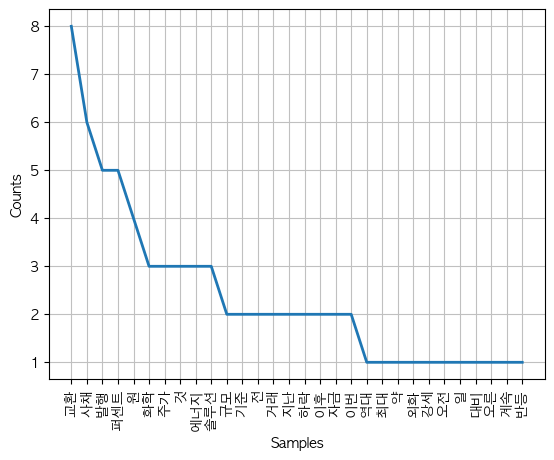

In [ ]:
# NLTK
from nltk import Text
from matplotlib import pyplot as plt

# 한글 폰트
from matplotlib import rc
rc('font', family='AppleGothic')

# 명사만
mynews = Text(okt.nouns(sent), name="mynews")
mynews.plot(30)
mynews
plt.show()

## nltk 연습

In [ ]:
import nltk

# 모든 형태소 (영어 포함)
tokens_ko = okt.morphs(sent)
ko = nltk.Text(tokens_ko, name='뉴스')

In [ ]:
# load tokens
print(len(ko.tokens))       # returns number of tokens (document length)
print(len(set(ko.tokens)))  # returns number of unique tokens
fd = ko.vocab()             # returns frequency distribution
print(type(fd))
fd

204
126
<class 'nltk.probability.FreqDist'>


FreqDist({'교환': 8, '.': 8, 'LG': 6, '사채': 6, '발행': 5, '은': 5, '퍼센트': 5, '으로': 5, '이': 4, '원': 4, ...})

In [ ]:
fd.most_common(10) # 출현 빈도 Top-10

[('교환', 8),
 ('.', 8),
 ('LG', 6),
 ('사채', 6),
 ('발행', 5),
 ('은', 5),
 ('퍼센트', 5),
 ('으로', 5),
 ('이', 4),
 ('원', 4)]

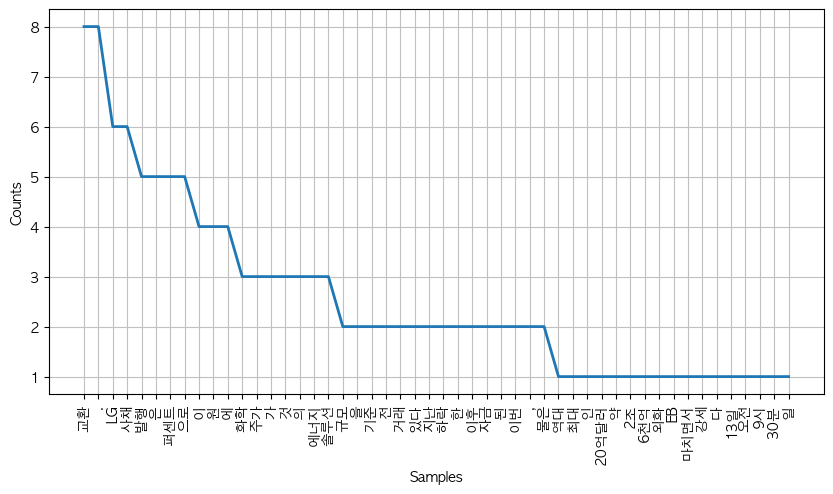

In [ ]:
# frequency distributions
plt.figure(figsize=(10,5))
ko.plot(50)     # Plot sorted frequency of top 50 tokens
plt.show()

In [ ]:
# 빈도수
ko.count('LG')

6

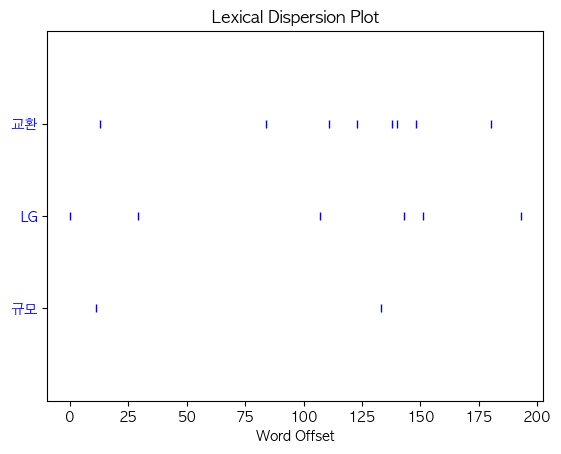

In [ ]:
# 분산 그래프: 위치와 빈도
ko.dispersion_plot(['교환', 'LG', '규모'])

In [ ]:
# 단어 좌우 00문자
ko.concordance('아세아', width=70, lines=50) # 좌우 200문자, 최대 50개까지

no matches


## nltk - 연어 찾기 연습

- 연어: 자주 함께 나타나는 경향이 있는 두 개 이상의 단어
- 영어 collocations: Miss Fairfax; every thing; young man; every body; great deal; dare say; John Knightley; Maple Grove; Miss Smith; Miss Taylor; Robert Martin; Colonel Campbell; Box Hill; said Emma; Harriet Smith; William Larkins
    
- 원리: n-gram
    - 2음절(2글자) 연어는 2-gram(Bigram), 3음절 연어는 3-gram(Trigram) 으로 찾음

### Kkma - 법령

In [ ]:
from konlpy.tag import Kkma
from konlpy.corpus import kolaw
from konlpy.utils import pprint
from nltk import collocations

measures = collocations.BigramAssocMeasures()

# 텍스트 불러오기
doc = kolaw.open('constitution.txt').read()

# bigram
# bigram + 품사 부착
print('\nCollocations among tagged words:')
tagged_words = Kkma().pos(doc) # 품사 부착
finder = collocations.BigramCollocationFinder.from_words(tagged_words)
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# bigram
print('\nCollocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'안녕'] # 불용어
finder = collocations.BigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 품사만
print('\nCollocations among tags:')
tags = [t for w, t in tagged_words] # 품사만 선택
finder = collocations.BigramCollocationFinder.from_words(tags)
pprint(finder.nbest(measures.pmi, 5))


Collocations among tagged words:
[(('가부', 'NNG'), ('동수', 'NNG')),
 (('강제', 'NNG'), ('노역', 'NNG')),
 (('경자', 'NNG'), ('유전', 'NNG')),
 (('고', 'ECS'), ('채취', 'NNG')),
 (('공무', 'NNG'), ('담임', 'NNG')),
 (('공중', 'NNG'), ('도덕', 'NNG')),
 (('과반', 'NNG'), ('수가', 'NNG')),
 (('교전', 'NNG'), ('상태', 'NNG')),
 (('그러', 'VV'), ('나', 'ECE')),
 (('기본적', 'NNG'), ('인권', 'NNG'))]

Collocations among words:
[('현행', '범인'),
 ('내부', '규율'),
 ('형의', '선고'),
 ('정치적', '중립성'),
 ('누구', '든지'),
 ('회계', '연도'),
 ('지체', '없이'),
 ('평화적', '통일'),
 ('형사', '피고인'),
 ('지방', '자치')]

Collocations among tags:
[('XR', 'XSA'), ('JKC', 'VCN'), ('EPT', 'EPT'), ('ECD', 'VX'), ('VCN', 'ECD')]


## Kkma - bigram - LG화학 / LG에너지솔루션 / 교환사채 잡히는가

In [ ]:
doc = selectsample(20, content=True)
doc

'LG화학이 역대 최대인 20억달러 약 2조6천억 원 규모 외화 교환사채 EB 발행을 마치면서 주가가 강세다. 13일 오전 9시 30분 기준 LG화학은 전 거래일 대비 1만5천 원 1.99퍼센트 오른 66만9천 원에 거래되고 있다. 지난 3일부터 주가가 계속 하락한 이후 반등한 것이다. 자금 조달 흥행에 따른 미래 신사업 기대감이 주가에 반영된 것으로 보인다. 이번 교환사채 수요예측에는 발행 목표의 5배에 달하는 자금 100억 달러 이 몰린 것으로 알려졌다. LG화학의 이번 교환사채 발행은 지난 2021년 이후 전 세계에서 발행된 교환사채와 전환사채 등 주식연계채권 중 규모가 가장 크다. 교환사채 교환 대상은 LG에너지솔루션으로, 교환 가격은 LG에너지솔루션 11일 종가 55만 원을 기준으로 주당 5년물은 25퍼센트, 7년물은 30퍼센트 수준의 높은 프리미엄으로 발행된다. 한편 교환사채 물량 출회 우려로 전날 3퍼센트 가까이 하락했던 LG에너지솔루션은 이날 0.94퍼센트 오르고 있다.'

In [ ]:
from konlpy.tag import Kkma
from konlpy.corpus import kolaw
from konlpy.utils import pprint
from nltk import collocations

measures = collocations.BigramAssocMeasures()
print(type(measures))
doc = selectsample(20, content=True)

# bigram
# 품사 부착
print('\nA. Collocations among tagged words:')
# tagged_words = okt.pos(doc) # 품사 부착
tagged_words = Kkma().pos(doc) # 품사 부착
finder = collocations.BigramCollocationFinder.from_words(tagged_words)
# finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 알고리즘: pmi
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.BigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 품사만
print('\nC. Collocations among tags:')
tags = [t for w, t in tagged_words] # 품사만 선택
finder = collocations.BigramCollocationFinder.from_words(tags)
pprint(finder.nbest(measures.pmi, 5))

<class 'nltk.metrics.association.BigramAssocMeasures'>

A. Collocations among tagged words:
[(('2', 'NR'), ('조', 'NR')),
 (('가장', 'MAG'), ('크', 'VA')),
 (('거래일', 'NNG'), ('대비', 'NNG')),
 (('높', 'VA'), ('은', 'ETD')),
 (('는', 'ETD'), ('자금', 'NNG')),
 (('달하', 'VV'), ('는', 'ETD')),
 (('대비', 'NNG'), ('1', 'NR')),
 (('등', 'NNB'), ('주식', 'NNG')),
 (('로', 'JKM'), ('전날', 'NNG')),
 (('마치', 'VV'), ('면서', 'ECE'))]

B. Collocations among words:
[('에너지', '솔루션'), ('LG', '에너지'), ('LG', '화학'), ('교환', '사채')]

C. Collocations among tags:
[('EPT', 'EFQ'), ('ECS', 'VXV'), ('MAG', 'VA'), ('ECE', 'VXV'), ('JKG', 'VA')]


- B: lg화학, 교환사채 ok

## Kkma - trigram

In [ ]:
measures = collocations.TrigramAssocMeasures()
print(type(measures))
doc = selectsample(20, content=True)

# bigram
# 품사 부착
print('\nA. Collocations among tagged words:')
# tagged_words = okt.pos(doc) # 품사 부착
tagged_words = Kkma().pos(doc) # 품사 부착
finder = collocations.TrigramCollocationFinder.from_words(tagged_words)
# finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 알고리즘: pmi
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.TrigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 품사만
print('\nC. Collocations among tags:')
tags = [t for w, t in tagged_words] # 품사만 선택
finder = collocations.TrigramCollocationFinder.from_words(tags)
pprint(finder.nbest(measures.pmi, 5))

<class 'nltk.metrics.association.TrigramAssocMeasures'>

A. Collocations among tagged words:
[(('2', 'NR'), ('조', 'NR'), ('6', 'NR')),
 (('거래일', 'NNG'), ('대비', 'NNG'), ('1', 'NR')),
 (('높', 'VA'), ('은', 'ETD'), ('프리미엄', 'NNG')),
 (('는', 'ETD'), ('자금', 'NNG'), ('100', 'NR')),
 (('달하', 'VV'), ('는', 'ETD'), ('자금', 'NNG')),
 (('등', 'NNB'), ('주식', 'NNG'), ('연계', 'NNG')),
 (('물량', 'NNG'), ('출회', 'NNG'), ('우려', 'NNG')),
 (('미래', 'NNG'), ('신사업', 'NNG'), ('기대감', 'NNG')),
 (('알리', 'VV'), ('어', 'ECS'), ('지', 'VXV')),
 (('약', 'NNG'), ('2', 'NR'), ('조', 'NR'))]

B. Collocations among words:
[('LG', '에너지', '솔루션')]

C. Collocations among tags:
[('ECS', 'VXV', 'EPT'),
 ('EPT', 'EFQ', 'OL'),
 ('XSV', 'EPT', 'EFQ'),
 ('JKS', 'MAG', 'VA'),
 ('VV', 'ECS', 'VXV')]


- B: LG에너지솔루션 ok
- Kkma().tagset에 외국어 있어서 외국어가 잘 잡힘  'OL': '외국어'

## okt - bigram

In [ ]:
measures = collocations.BigramAssocMeasures()
print(type(measures))
doc = selectsample(20, content=True)

# bigram
# 품사 부착
print('\nA. Collocations among tagged words:')
tagged_words = okt.pos(doc) # 품사 부착
# tagged_words = Kkma().pos(doc) # 품사 부착
finder = collocations.BigramCollocationFinder.from_words(tagged_words)
# finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 알고리즘: pmi
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.BigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 품사만
print('\nC. Collocations among tags:')
tags = [t for w, t in tagged_words] # 품사만 선택
finder = collocations.BigramCollocationFinder.from_words(tags)
pprint(finder.nbest(measures.pmi, 5))

<class 'nltk.metrics.association.BigramAssocMeasures'>

A. Collocations among tagged words:
[(('100억', 'Number'), ('달러', 'Noun')),
 (('11일', 'Number'), ('종가', 'Noun')),
 (('13일', 'Number'), ('오전', 'Noun')),
 (('1만', 'Number'), ('5천', 'Number')),
 (('20억달러', 'Number'), ('약', 'Noun')),
 (('2조', 'Number'), ('6천억', 'Number')),
 (('3일', 'Number'), ('부터', 'Foreign')),
 (('5', 'Number'), ('배', 'Noun')),
 (('66만', 'Number'), ('9천', 'Number')),
 (('9시', 'Number'), ('30분', 'Number'))]

B. Collocations among words:
[('에너지', '솔루션'), ('LG', '에너지'), ('LG', '화학'), ('교환', '사채')]

C. Collocations among tags:
[('Adjective', 'Punctuation'),
 ('Verb', 'Adjective'),
 ('Number', 'Foreign'),
 ('Modifier', 'Modifier'),
 ('Josa', 'Determiner')]


In [ ]:
# 4회 이상 출현 단어
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.BigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(4) ###### 변경
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI


B. Collocations among words:
[('교환', '사채')]


### okt - bigram - 다른 예제
- 의미 있는 bigram 없으면, 대신 '퍼센트 증가' 등이 출력되기도 함

In [ ]:
measures = collocations.BigramAssocMeasures()
print(type(measures))
doc = selectsample(200, content=True)

# bigram
# 품사 부착
tagged_words = okt.pos(doc) # 품사 부착

# 알고리즘: pmi
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.BigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

<class 'nltk.metrics.association.BigramAssocMeasures'>

B. Collocations among words:
[('동기', '대비'), ('퍼센트', '증가')]


In [ ]:
measures = collocations.BigramAssocMeasures()
print(type(measures))
doc = selectsample(500, content=True)

# bigram
# 품사 부착
tagged_words = okt.pos(doc) # 품사 부착

# 알고리즘: pmi
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.BigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

<class 'nltk.metrics.association.BigramAssocMeasures'>

B. Collocations among words:
[('원자재', '가격'),
 ('전월', '대비'),
 ('화학', '제품'),
 ('물가', '지수'),
 ('수입', '물가'),
 ('수출', '물가'),
 ('하락', '했다'),
 ('2.8', '퍼센트'),
 ('퍼센트', '내렸다'),
 ('퍼센트', '하락')]


## okt - trigram

In [ ]:
measures = collocations.TrigramAssocMeasures()
print(type(measures))
doc = selectsample(20, content=True)

# bigram
# 품사 부착
print('\nA. Collocations among tagged words:')
tagged_words = okt.pos(doc) # 품사 부착
# tagged_words = Kkma().pos(doc) # 품사 부착
finder = collocations.TrigramCollocationFinder.from_words(tagged_words)
# finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 알고리즘: pmi
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.TrigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(3) # only bigrams that appear 3+ times
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI

# 품사만
print('\nC. Collocations among tags:')
tags = [t for w, t in tagged_words] # 품사만 선택
finder = collocations.TrigramCollocationFinder.from_words(tags)
pprint(finder.nbest(measures.pmi, 5))

<class 'nltk.metrics.association.TrigramAssocMeasures'>

A. Collocations among tagged words:
[(('100억', 'Number'), ('달러', 'Noun'), ('이', 'Noun')),
 (('11일', 'Number'), ('종가', 'Noun'), ('55만', 'Number')),
 (('13일', 'Number'), ('오전', 'Noun'), ('9시', 'Number')),
 (('20억달러', 'Number'), ('약', 'Noun'), ('2조', 'Number')),
 (('계', 'Noun'), ('채권', 'Noun'), ('중', 'Noun')),
 (('달러', 'Noun'), ('이', 'Noun'), ('몰린', 'Verb')),
 (('대비', 'Noun'), ('1만', 'Number'), ('5천', 'Number')),
 (('등', 'Noun'), ('주식', 'Noun'), ('연', 'Modifier')),
 (('따른', 'Verb'), ('미래', 'Noun'), ('신', 'Modifier')),
 (('로', 'Josa'), ('전날', 'Noun'), ('3', 'Number'))]

B. Collocations among words:
[('LG', '에너지', '솔루션')]

C. Collocations among tags:
[('Verb', 'Adjective', 'Punctuation'),
 ('Punctuation', 'Number', 'Foreign'),
 ('Number', 'Foreign', 'Number'),
 ('Verb', 'Number', 'Foreign'),
 ('Verb', 'Punctuation', 'Alpha')]


In [ ]:
# 2회 이상 출현 단어로 기준 낮춤
print('\nB. Collocations among words:')
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다 되었다 됐다 하다 하였다 했다 이다 이었다 였다 있다 없다'] # 불용어
finder = collocations.TrigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
finder.apply_freq_filter(2)
pprint(finder.nbest(measures.pmi, 10)) # top 10 n-grams with highest PMI


B. Collocations among words:
[('LG', '에너지', '솔루션'), ('이번', '교환', '사채')]


In [ ]:
okt.pos('금리인상')

[('금리', 'Noun'), ('인상', 'Noun')]

## 결론
- threshold: 기본 3회로 하되, bigram에선 4회 이상으로 높여도 됨
- 명사+명사만 분석 대상으로 놓아도 될 듯


### 최종 코드: 명사+명사 연어 찾기

In [ ]:
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import TrigramAssocMeasures
from nltk.metrics.association import QuadgramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import QuadgramCollocationFinder
from collections import Counter

ngram = [(BigramAssocMeasures(),BigramCollocationFinder),
         (TrigramAssocMeasures(),TrigramCollocationFinder),
          (QuadgramAssocMeasures(),QuadgramCollocationFinder)]

# 텍스트 지정
doc = selectsample(500, content=True)
print('제목/', selectsample(500, content=False))
print(' ')
print('본문/', doc)
print(' ')

# 형태소 분석기 - 명사만 추출
okt = Okt()
nouns = okt.nouns(doc) # get nouns
tagged_words = okt.pos(doc) # 품사 부착
words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
ignored_words = [u'되다', '되었다', '됐다', '하다', '하였다', '했다', '이다', '이었다', '였다', '있다', '없다'] # 불용어

# 각 알고리즘별로 bigram, trigram, quadgram 10개씩 뽑아 리스트 만들기
founds_from_4measure = []
for measure, finder in ngram:
    '''명사 vs 전체 단어 택 1'''
#     finder = finder.from_words(nouns)
    finder = finder.from_words(words) # 숫자, 알파벳(LG, NH), 영어 포함

    finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
    finder.apply_freq_filter(3) # only bigrams that appear 3+ times
    founds = finder.nbest(measure.pmi, 10)       # pmi - 상위 10개 추출
    founds += finder.nbest(measure.chi_sq, 10)   # chi_sq - 상위 10개 추출
    founds += finder.nbest(measure.mi_like, 10)  # mi_like - 상위 10개 추출
    founds += finder.nbest(measure.jaccard, 10)  # jaccard - 상위 10개 추출

    founds_from_4measure += founds

# 나뉜 연어를 한 단어로 묶고, 3/4 voting된 최종 연어 출력
collocations = [' '.join(collocation) for collocation in founds_from_4measure]
collocations = [(w,f) for w,f in Counter(collocations).most_common() if f > 2]
pprint(collocations)

제목/ 원화가치 상승에 수출입 물가 두 달 연속 하락
 
본문/ 지난달 달러 약세로 원화 가치가 상승하고 원자재 가격이 내리면서 수출과 수입 제품 모두 전반적인 가격 수준이 2개월 연속 하락했다. 한국은행이 13일 발표한 수출입물가지수 통계에 따르면 지난 6월 기준 수출물가지수 원화 기준 잠정치 2015 년 수준 100 는 113.13으로 5월 116.43 보다 2.8퍼센트 하락했다. 수출물가지수는 지난 2월부터 전월 대비 석 달 연속 올랐으나, 5월 하락세로 돌아선 뒤 6월에도 내렸다. 품목별로 보면 화학제품 4.9 퍼센트 과 제1차 금속제품 3.6 퍼센트 등이 수출 물가를 끌어내렸다. 서정석 한은 물가통계팀장은 화학제품이 원자재 가격 하락, 중국 생산설비 증설에 따른 공급 증가, 전방산업 수요 부진 등으로 인해 하락했다 며 제1차 금속제품도 원자재 가격하락, 수요 부진 영향을 받았다 고 설명했다. 세부 품목으로는 자일렌 8.0 퍼센트 , 냉연 강대 8.3 퍼센트 , 나프타 6.4 퍼센트 , D램 3.9 퍼센트 등이 내렸다. 지난달 평균 달러당 원화값은 1296.71원으로 전월 대비 2.4퍼센트 내렸다. 환율 영향을 제거한 계약통화 기준 수출 물가는 전월 대비 0.5퍼센트 하락했다. 6월 수입물가지수는 130.49로 5월 135.10 보다 3.4퍼센트 하락했다. 수입물가지수 역시 전월 대비 두 달 연속 내림세다. 용도별로 원재료는 광산품 2.8 퍼센트 을 중심으로 2.8퍼센트 하락했고, 중간재는 석탄 석유제품 10.1 퍼센트 , 화학제품 5.2 퍼센트 등이 내리면서 4.5퍼센트 하락했다. 자본재와 소비재는 각각 2.6퍼센트, 2.1퍼센트 내렸다. 세부 품목으로는 프로판가스 20.8 퍼센트 , 부탄가스 22.6 퍼센트 , 나프타 12.1 퍼센트 , 기타귀금속정련품 14.1 퍼센트 등이 많이 하락했다. 서 팀장은 국제유가가 6월에는 전월 대비 큰 변동이 없었지만, 5월 하락분이 수입 물가에 영향을 주고 있다 고 설명했다. 지난달 국제 유가는 평균 74.99달러 

## 함수 - 행 하나

In [ ]:
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import TrigramAssocMeasures
from nltk.metrics.association import QuadgramAssocMeasures
from nltk.collocations import BigramCollocationFinder

def collocations_single(num):

    ngram = [(BigramAssocMeasures(),BigramCollocationFinder),
             (TrigramAssocMeasures(),TrigramCollocationFinder),
              (QuadgramAssocMeasures(),QuadgramCollocationFinder)]

    # 텍스트 지정, 출력
    doc = selectsample(num, content=True)
    print('제목/', selectsample(num, content=False))
    print(' ')
    print('본문/', doc)
    print(' ')

    # 형태소 분석기 - 명사만 추출
    okt = Okt()
    nouns = okt.nouns(doc) # get nouns
    tagged_words = okt.pos(doc) # 품사 부착
    words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
    ignored_words = [u'되다', '되었다', '됐다', '하다', '하였다', '했다', '이다', '이었다', '였다', '있다', '없다'] # 불용어

    # 각 알고리즘별로 bigram, trigram, quadgram 10개씩 뽑아 리스트 만들기
    founds_from_4measure = []
    for measure, finder in ngram:
        '''명사 vs 전체 단어 택 1'''
    #     finder = finder.from_words(nouns)
        finder = finder.from_words(words) # 숫자, 알파벳(LG, NH), 영어 포함

        finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
        finder.apply_freq_filter(3) # only bigrams that appear 3+ times
        founds = finder.nbest(measure.pmi, 10)       # pmi - 상위 10개 추출
        founds += finder.nbest(measure.chi_sq, 10)   # chi_sq - 상위 10개 추출
        founds += finder.nbest(measure.mi_like, 10)  # mi_like - 상위 10개 추출
        founds += finder.nbest(measure.jaccard, 10)  # jaccard - 상위 10개 추출

        founds_from_4measure += founds

    # 나뉜 연어를 한 단어로 묶고, 3/4 voting된 최종 연어 출력
    collocations = [' '.join(collocation) for collocation in founds_from_4measure]
    collocations = [(w,f) for w,f in Counter(collocations).most_common() if f > 2]
    pprint(collocations)

In [ ]:
collocations_single(500)

제목/ 원화가치 상승에 수출입 물가 두 달 연속 하락
 
본문/ 지난달 달러 약세로 원화 가치가 상승하고 원자재 가격이 내리면서 수출과 수입 제품 모두 전반적인 가격 수준이 2개월 연속 하락했다. 한국은행이 13일 발표한 수출입물가지수 통계에 따르면 지난 6월 기준 수출물가지수 원화 기준 잠정치 2015 년 수준 100 는 113.13으로 5월 116.43 보다 2.8퍼센트 하락했다. 수출물가지수는 지난 2월부터 전월 대비 석 달 연속 올랐으나, 5월 하락세로 돌아선 뒤 6월에도 내렸다. 품목별로 보면 화학제품 4.9 퍼센트 과 제1차 금속제품 3.6 퍼센트 등이 수출 물가를 끌어내렸다. 서정석 한은 물가통계팀장은 화학제품이 원자재 가격 하락, 중국 생산설비 증설에 따른 공급 증가, 전방산업 수요 부진 등으로 인해 하락했다 며 제1차 금속제품도 원자재 가격하락, 수요 부진 영향을 받았다 고 설명했다. 세부 품목으로는 자일렌 8.0 퍼센트 , 냉연 강대 8.3 퍼센트 , 나프타 6.4 퍼센트 , D램 3.9 퍼센트 등이 내렸다. 지난달 평균 달러당 원화값은 1296.71원으로 전월 대비 2.4퍼센트 내렸다. 환율 영향을 제거한 계약통화 기준 수출 물가는 전월 대비 0.5퍼센트 하락했다. 6월 수입물가지수는 130.49로 5월 135.10 보다 3.4퍼센트 하락했다. 수입물가지수 역시 전월 대비 두 달 연속 내림세다. 용도별로 원재료는 광산품 2.8 퍼센트 을 중심으로 2.8퍼센트 하락했고, 중간재는 석탄 석유제품 10.1 퍼센트 , 화학제품 5.2 퍼센트 등이 내리면서 4.5퍼센트 하락했다. 자본재와 소비재는 각각 2.6퍼센트, 2.1퍼센트 내렸다. 세부 품목으로는 프로판가스 20.8 퍼센트 , 부탄가스 22.6 퍼센트 , 나프타 12.1 퍼센트 , 기타귀금속정련품 14.1 퍼센트 등이 많이 하락했다. 서 팀장은 국제유가가 6월에는 전월 대비 큰 변동이 없었지만, 5월 하락분이 수입 물가에 영향을 주고 있다 고 설명했다. 지난달 국제 유가는 평균 74.99달러 

In [ ]:
df['title+content_p'] = df[['title_p', 'content_p']].apply(' '.join, axis=1)
df.head()

,date,title,content,press,link,title_p,content_p,len,title+content,title+content_p
0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발 국토...","차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발 국토부, 7..."
1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신 작년 9월 ...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신 작년 9월 출시 후 선풍적...
2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여 6월 기준 서울 전...",전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여 6월 기준 서울 전세비...
3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위 ※한경 마켓PRO 텔레그램을 구독...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위 한경 마켓PRO 텔레그램을 구독하시면...
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’ 8거래일간 100% 넘게 뛰다...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아 8거래일간 100퍼센트 넘게 뛰다 ...


In [ ]:
def collocations_(df, col='title+content_p'):

    ngram = [(BigramAssocMeasures(),BigramCollocationFinder),
             (TrigramAssocMeasures(),TrigramCollocationFinder),
              (QuadgramAssocMeasures(),QuadgramCollocationFinder)]
    collocations_list = []
    for doc in tqdm(df[col]):

        # 형태소 분석기 - 명사만 추출
        okt = Okt()
        nouns = okt.nouns(doc) # get nouns
        tagged_words = okt.pos(doc) # 품사 부착
        words = [w for w, t in tagged_words] # 단어+품사 중 단어만 선택
        ignored_words = [u'되다', '되었다', '됐다', '하다', '하였다', '했다', '이다', '이었다', '였다', '있다', '없다'] # 불용어

        # 각 알고리즘별로 bigram, trigram, quadgram 10개씩 뽑아 리스트 만들기
        founds_from_4measure = []
        for measure, finder in ngram:
            '''명사 vs 전체 단어 택 1'''
        #     finder = finder.from_words(nouns)
            finder = finder.from_words(words) # 숫자, 알파벳(LG, NH), 영어 포함

            finder.apply_word_filter(lambda w: len(w) < 2 or w in ignored_words) # 제외조건: 길이가 1이거나 ignored_words에 포함되면 제외
            finder.apply_freq_filter(3) # only bigrams that appear 3+ times
            founds = finder.nbest(measure.pmi, 10)       # pmi - 상위 10개 추출
            founds += finder.nbest(measure.chi_sq, 10)   # chi_sq - 상위 10개 추출
            founds += finder.nbest(measure.mi_like, 10)  # mi_like - 상위 10개 추출
            founds += finder.nbest(measure.jaccard, 10)  # jaccard - 상위 10개 추출

            founds_from_4measure += founds

        # 나뉜 연어를 한 단어로 묶고, 3/4 voting된 최종 연어 출력
        collocations = [' '.join(collocation) for collocation in founds_from_4measure]
        collocations = [(w,f) for w,f in Counter(collocations).most_common() if f > 2]
        collocations_list.append(collocations)

    return collocations_list

In [ ]:
df['collocation'] = collocations_(df, 'title+content_p')
df[['title+content_p', 'collocation']].head()

  0%|          | 0/1573 [00:00<?, ?it/s]

,title+content_p,collocation
0,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발 국토부, 7...","[(2년 연속, 4), (특별법 시행, 4), (민간 임대주택, 4), (126 퍼..."
1,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신 작년 9월 출시 후 선풍적...,"[(제로 슈거, 4)]"
2,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여 6월 기준 서울 전세비...,"[(지난 5월, 4), (임대 수요, 4), (서울 아파트, 4), (퍼센트 대로,..."
3,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위 한경 마켓PRO 텔레그램을 구독하시면...,"[(마켓 PRO, 4), (소비자 물가, 4), (금리 인상, 4)]"
4,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아 8거래일간 100퍼센트 넘게 뛰다 ...,"[(한국 거래소, 4)]"


In [ ]:
import openpyxl
# df = df.drop(['title+content'], axis=1)
df.to_excel('텍스트 전처리+collocations_230729_홍주.xlsx') # 저장
pd.read_excel('텍스트 전처리+collocations_230729_홍주.xlsx', index_col=0) # 확인

,date,title,content,press,link,title_p,content_p,len,collocation
0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"[('2년 연속', 4), ('특별법 시행', 4), ('민간 임대주택', 4), ..."
1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"[('제로 슈거', 4)]"
2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"[('지난 5월', 4), ('임대 수요', 4), ('서울 아파트', 4), ('..."
3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"[('마켓 PRO', 4), ('소비자 물가', 4), ('금리 인상', 4)]"
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"[('한국 거래소', 4)]"
...,...,...,...,...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"[('보험 청구', 4), ('실업 보험', 4), ('연방 준비', 4), ('생..."
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,머니S,https://n.news.naver.com/mnews/article/417/000...,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"[('IFRS 17', 4), ('수입 보험료', 4), ('보험 연구원', 4),..."
1570,2023-07-14 05:46:01,"""어쩌다 이렇게까지"" 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자…수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,아이뉴스24,https://n.news.naver.com/mnews/article/031/000...,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"[('오퍼 레이', 4), ('실적 개선', 4), ('기업 가치', 4), ('신..."
1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승...엔비디아 4.7%↑",[파이낸셜뉴스] 뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승 엔비디아 4.7퍼센트",파이낸셜뉴스 뉴욕증시가 13일 이하 현지시간 대형 기술주 강세 속에 상승세를 이어갔...,1941,"[('미래 수익', 4), ('예상 보다', 4), ('대형 기술', 4), ('물..."


## 3. 동의어 사전 (선택사항)
- 같은 단어인데 한글/영어, 한글/한자(내렸다, 하락)
- 이형동의어: 연준(연방준비제도), 한은(한국은행), 이 총재 (이창용 총재)

# IV. TF_IDF_후_형태소_분석기_OKT_사용- 불용어랑 명사키워드 추가

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

In [ ]:
df = df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/텍스트 전처리+collocations_230729_홍주.xlsx")
# 명사구 키워드를 합친 데이터셋
# 본문과 제목은 특수기호와 뉴스 기사라서 형식적으로 들어가있는 기자와 같은 단어를 빼는 전처리 작업을 진행해줌
# 위 화살표 같은 특수기호는 증가와 동일한 의미를 지니고 있다고 판단하여 문자로 바꾸어주었음
df1 = df
df1

,Unnamed: 0,date,title,content,press,link,title_p,content_p,len,collocation
0,0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"[('2년 연속', 4), ('특별법 시행', 4), ('민간 임대주택', 4), ..."
1,1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"[('제로 슈거', 4)]"
2,2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"[('지난 5월', 4), ('임대 수요', 4), ('서울 아파트', 4), ('..."
3,3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"[('마켓 PRO', 4), ('소비자 물가', 4), ('금리 인상', 4)]"
4,4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"[('한국 거래소', 4)]"
...,...,...,...,...,...,...,...,...,...,...
1568,1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"[('보험 청구', 4), ('실업 보험', 4), ('연방 준비', 4), ('생..."
1569,1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,머니S,https://n.news.naver.com/mnews/article/417/000...,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"[('IFRS 17', 4), ('수입 보험료', 4), ('보험 연구원', 4),..."
1570,1570,2023-07-14 05:46:01,"""어쩌다 이렇게까지"" 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자…수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,아이뉴스24,https://n.news.naver.com/mnews/article/031/000...,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"[('오퍼 레이', 4), ('실적 개선', 4), ('기업 가치', 4), ('신..."
1571,1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승...엔비디아 4.7%↑",[파이낸셜뉴스] 뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승 엔비디아 4.7퍼센트",파이낸셜뉴스 뉴욕증시가 13일 이하 현지시간 대형 기술주 강세 속에 상승세를 이어갔...,1941,"[('미래 수익', 4), ('예상 보다', 4), ('대형 기술', 4), ('물..."


In [ ]:
df1['collocation'][19]

"[('소액 단기', 4), ('가입 기간', 4), ('교보 생명', 4), ('사업 모델', 4), ('카카오 페이', 4), ('신한 EZ', 4), ('EZ 손보', 4), ('디지털 보험사', 4), ('신한 EZ 손보', 4), ('장기 보험', 3)]"

In [ ]:
df1['TF-keywords'] = None

In [ ]:
# TF-IDF 사용을 위한 라이브러리 설치 및 준비
from sklearn.feature_extraction.text import TfidfVectorizer


tfidfv = TfidfVectorizer()


In [ ]:
# TF-IDF를 사영하여 문서 벡터화 진행
tfidf_matrix = tfidfv.fit_transform(df1['content_p'])

for i in range(len(df1)):
    doc_tfidf = tfidf_matrix[i].toarray().flatten() # 벡터화시킨 것을 다시 문자로
    sorted_indices = doc_tfidf.argsort()[::-1] # tf-idf값이 높을수록 중요한 키워드인데 높은 순으로 정렬
    top_keywords = [tfidfv.get_feature_names_out()[idx] for idx in sorted_indices[:15]]  # 상위 10개 단어만 추출 # 숫자나 영어 단어만 나올 경우 제거하고 다음 키워드를 올려서 쓸거기 때문에 넉넉히 뽑음
    # 키워드를 저장할 빈 리스트 생성
    keywords = []
    keywords.append(top_keywords)
    # 각 행에 알맞은 키워드 부여
    df1['TF-keywords'][i] = keywords
print(df1['TF-keywords'][:10])

<ipython-input-15-30b5aae11159>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['TF-keywords'][i] = keywords


0    [[임대보증금, 공시가격의, 임대인, 특별법, 보증금, 임대인들이, 민간임대주택에,...
1    [[제로, 열량은, 말티톨은, 발암, 설탕, 아스파탐, 다이어트에, 설탕이, 열량,...
2    [[월세, 전세, 대출, 아파트, 전세대출, 전세로, 수요가, 임대, 주택, 서울,...
3    [[듯하다, 소비자물가는, 안으로는, 금리인상을, 마켓pro, 여겨진다, 고용과, ...
4    [[2차전지, 금양의, 공매도, 금양, 주가, 원을, 금양에, 발포제, 배로, 한국...
5    [[무상증자를, 1주당, 유상증자를, 보통주, 기업들이, 투자자들에게, 탓이다, 주...
6    [[p500의, 브로드컴은, arm, cpi, 지수는, 최저를, 로이터에, 경쟁사,...
7    [[하루인베스트, 가상자산, 하루인베스트는, 출금, 피해자들은, 박씨는, 자산, 이...
8    [[연준은, 사정권에, 근원, 주택, 인플레이션이, 불구하고, 기대했다, cpi보다...
9    [[가계대출, 은행권, 증가, 주담대, 기타대출, 입주물량, 전월, 가계대출도, 잔...
Name: TF-keywords, dtype: object


In [ ]:
df1['TF-keywords'][0][0]

['임대보증금',
 '공시가격의',
 '임대인',
 '특별법',
 '보증금',
 '임대인들이',
 '민간임대주택에',
 '보증보험',
 '집단',
 '시행령',
 '전세보증금',
 '자진말소를',
 '가입요건',
 '과태료',
 '임대인의']

In [ ]:
df1.head()

,Unnamed: 0,date,title,content,press,link,title_p,content_p,len,collocation,TF-keywords
0,0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"[('2년 연속', 4), ('특별법 시행', 4), ('민간 임대주택', 4), ...","[[임대보증금, 공시가격의, 임대인, 특별법, 보증금, 임대인들이, 민간임대주택에,..."
1,1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"[('제로 슈거', 4)]","[[제로, 열량은, 말티톨은, 발암, 설탕, 아스파탐, 다이어트에, 설탕이, 열량,..."
2,2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"[('지난 5월', 4), ('임대 수요', 4), ('서울 아파트', 4), ('...","[[월세, 전세, 대출, 아파트, 전세대출, 전세로, 수요가, 임대, 주택, 서울,..."
3,3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"[('마켓 PRO', 4), ('소비자 물가', 4), ('금리 인상', 4)]","[[듯하다, 소비자물가는, 안으로는, 금리인상을, 마켓pro, 여겨진다, 고용과, ..."
4,4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"[('한국 거래소', 4)]","[[2차전지, 금양의, 공매도, 금양, 주가, 원을, 금양에, 발포제, 배로, 한국..."


In [ ]:
# 키워드들이 리스트 속에 리스트로 저장되어 있기 대문에 리스트 하나를 언패킹해주는 작업이 필요함

for i in range(len(df1['TF-keywords'])):
  df1['TF-keywords'][i] = df1['TF-keywords'][i][0]

df1['TF-keywords'][0]

<ipython-input-19-70751cbcb681>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['TF-keywords'][i] = df1['TF-keywords'][i][0]


['임대보증금',
 '공시가격의',
 '임대인',
 '특별법',
 '보증금',
 '임대인들이',
 '민간임대주택에',
 '보증보험',
 '집단',
 '시행령',
 '전세보증금',
 '자진말소를',
 '가입요건',
 '과태료',
 '임대인의']

In [ ]:
# TF-IDF를 사용하여 키워드를 잡은 후 추출된 키워들에 붙은 을/를 특수기호 같은 것들을 제거해줌

In [ ]:
# okt 형태소 분석기를 위한 라이브러리 설치 및 준비
!pip install konlpy

from konlpy.tag import Okt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 48.3 MB/s eta 0:00:00


In [ ]:
# 형태소 분석기 지정
okt = Okt()

In [ ]:
df1['new_key'] = None

In [ ]:
len(df1['TF-keywords'][0])

15

In [ ]:
# 형태소 분석 결과 확인
for i in range(len(df1['TF-keywords'])):
  for j in range(len(df1['TF-keywords'][i])):
    print(okt.pos(df1['TF-keywords'][i][j]))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[('펜션', 'Noun'), ('과', 'Josa')]
[('강상면', 'Noun')]
[('설치', 'Noun')]
[('양서면', 'Noun'), ('은', 'Josa')]
[('전원주택', 'Noun'), ('이', 'Josa')]
[('대표이사', 'Noun')]
[('kt', 'Alpha'), ('는', 'Verb')]
[('사내', 'Noun')]
[('심사', 'Noun'), ('의', 'Josa')]
[('후보', 'Noun'), ('군', 'Suffix'), ('에', 'Josa')]
[('서류', 'Noun')]
[('이', 'Determiner'), ('사', 'Modifier'), ('후보', 'Noun'), ('추천', 'Noun'), ('위원회', 'Noun'), ('는', 'Josa')]
[('전문성', 'Noun')]
[('후보', 'Noun'), ('를', 'Josa')]
[('이사', 'Noun'), ('를', 'Josa')]
[('이사회', 'Noun')]
[('심사', 'Noun'), ('를', 'Josa')]
[('후보', 'Noun')]
[('외부', 'Noun')]
[('의견', 'Noun'), ('을', 'Josa')]
[('대안', 'Noun')]
[('타당성조사', 'Noun')]
[('대안', 'Noun'), ('이', 'Josa')]
[('노선', 'Noun'), ('이', 'Josa')]
[('노선', 'Noun')]
[('종점', 'Noun'), ('부인', 'Noun')]
[('바뀌었다는', 'Verb')]
[('국토부', 'Noun')]
[('보고', 'Noun'), ('됐다', 'Verb')]
[('인수위', 'Noun')]
[('부사', 'Noun'), ('장', 'Suffix'), ('은', 'Josa')]
[('특혜', 'Noun'), ('를', 'Josa')]
[('예', 'Modifier'), ('타', 'Noun'), ('와'

In [ ]:
# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 사전 파일을 읽어와서 불용어 사전 구성
# 배포되어 있는 불용어 사전에 개인작업으로 추가 불용어들 추가
with open('/content/drive/MyDrive/Colab Notebooks/new_stopwords.txt', 'r', encoding='utf-8') as f:
    korean_stopwords = set(f.read().splitlines())

# 형태소 분석 후 명사와 숫자, 알파벳, 접미사만 남기는 함수 정의
def filter_words(text):
    morphemes = okt.pos(text)
    filtered_words = [word for word, pos in morphemes if pos in ['Noun', 'Number', 'Alpha', 'Suffix'] and word not in korean_stopwords]
    return ' '.join(filtered_words)

# 빈 리스트 할당
df1['new_key'] = [[] for _ in range(len(df1['TF-keywords']))]

for i in range(len(df1['TF-keywords'])):
    for j in range(len(df1['TF-keywords'][i])):
        filtered_words = filter_words(df1['TF-keywords'][i][j])
        df1['new_key'][i].append(filtered_words)

print(df1['new_key'])


0       [임대 보증금, 공시가격, 임대, 특별법, 보증금, 임대, 민간 임대주택, 보증 보...
1       [제로, 열량, 말티톨, 발암, 설탕, 아스파탐, 다이어트, 설탕, 열량, 진로, ...
2       [월세, 전세, 대출, 아파트, 전세 대출, 전세, 수요, 임대, 주택, 서울, 가...
3       [듯, 소비자 물가, , 금리 인상, 마켓 pro, , 고용, 가운데, 방향성, 입...
4       [2, 금 양, 공매도, 금 양, 주가, 원, 금 양, 발포, 배, 한국 항공우주,...
                              ...                        
1568    [준, 주간, 전장, 금리, 불러드, 투자자, 전달, 청구, 실업 보험, , 생산자...
1569    [수입 보험료, 보험사, 보험사, csm, csm 은, 보험, 생명 보험사, 보험 ...
1570    [imm, pe, 샘, 신임, 김유진, 경영, 대표, 개선, 적자, 김진태, 샘, ...
1571    [아마존, 금리 인상, 일비, 로웬 가트, 54달러, 상승, , 전날, 프라임 데이...
1572    [가계부채, 총재, gdp, 가계부채, 부동산, 배경, 문제, 가계 대출, 금리, ...
Name: new_key, Length: 1573, dtype: object


In [ ]:
# 어색한 키워드들 확인
print(df1['TF-keywords'][4]) # 2차전지 > 2 : 숫자 차전지 : 동사
print(df1['TF-keywords'][5]) # 1주당 > 1 : 숫자 주당 : 동사

['2차전지', '금양의', '공매도', '금양', '주가', '원을', '금양에', '발포제', '배로', '한국항공우주', '금양은', '원통형', '급등에', '6조', '한국거래소']
['무상증자를', '1주당', '유상증자를', '보통주', '기업들이', '투자자들에게', '탓이다', '주가가', '에스씨엠생명과학', '단행한다는', '주주배정후', '일반공모방식으로', '유상증자와', '기업가치에', '유상증자는']


In [ ]:
# 띄어쓰기를 없애는 함수 정의
def remove_whitespace(text_list):
    return [text.replace(" ", "") for text in text_list]

# df1['keywords']에 적용하여 띄어쓰기 없애기
df1['new_key'] = df1['new_key'].apply(remove_whitespace)

# 각 행에 있는 리스트에서 " "이거나 비어있는 인덱스를 제외하는 함수 정의
def remove_empty_and_whitespace_from_list(text_list):
    # 단어가 1개 이상의 문자로 이루어진 경우에만 유지하도록 조건 추가
    return [text for text in text_list if text.strip() != "" and len(text) > 1]

# df1['keywords']에 적용하여 " "이거나 비어있는 인덱스와 하나의 문자로만 이루어진 단어 제외
df1['new_key'] = df1['new_key'].apply(remove_empty_and_whitespace_from_list)

# 결과 출력
print(df1['new_key'])


0       [임대보증금, 공시가격, 임대, 특별법, 보증금, 임대, 민간임대주택, 보증보험, ...
1       [제로, 열량, 말티톨, 발암, 설탕, 아스파탐, 다이어트, 설탕, 열량, 진로, ...
2       [월세, 전세, 대출, 아파트, 전세대출, 전세, 수요, 임대, 주택, 서울, 가격...
3       [소비자물가, 금리인상, 마켓pro, 고용, 가운데, 방향성, 입장, 25bp, 비...
4       [금양, 공매도, 금양, 주가, 금양, 발포, 한국항공우주, 금양은, 원통형, 급등...
                              ...                        
1568    [주간, 전장, 금리, 불러드, 투자자, 전달, 청구, 실업보험, 생산자, 기업, ...
1569    [수입보험료, 보험사, 보험사, csm, csm은, 보험, 생명보험사, 보험연구원,...
1570    [imm, pe, 신임, 김유진, 경영, 대표, 개선, 적자, 김진태, 부지, pe...
1571    [아마존, 금리인상, 일비, 로웬가트, 54달러, 상승, 전날, 프라임데이, 시장,...
1572    [가계부채, 총재, gdp, 가계부채, 부동산, 배경, 문제, 가계대출, 금리, 총...
Name: new_key, Length: 1573, dtype: object


In [ ]:
# 복사본 미리 만들어두기
df2 = df1.copy()

In [ ]:
# 각 행에 있는 리스트에서 왼쪽에서부터 5개만 남기는 함수 정의
def keep_first_5_elements(text_list):
    return text_list[:5]

# df1['keywords']에 적용하여 각 행에서 왼쪽에서부터 5개만 남기기
df2['new_key'] = df2['new_key'].apply(keep_first_5_elements)

# 결과 출력
print(df2['new_key'])

# 같은 단어가 반복되는 경우 존재

# 숫자만 있는거는 의미가 딱히 없을 거 같음
# 금리 3.6%pt 인상이면 금리인상이라는 키워드만 잡혀도 괜찮지 않을까??


0         [임대보증금, 공시가격, 임대, 특별법, 보증금]
1               [제로, 열량, 말티톨, 발암, 설탕]
2             [월세, 전세, 대출, 아파트, 전세대출]
3       [소비자물가, 금리인상, 마켓pro, 고용, 가운데]
4               [금양, 공매도, 금양, 주가, 금양]
                    ...              
1568           [주간, 전장, 금리, 불러드, 투자자]
1569     [수입보험료, 보험사, 보험사, csm, csm은]
1570           [imm, pe, 신임, 김유진, 경영]
1571      [아마존, 금리인상, 일비, 로웬가트, 54달러]
1572       [가계부채, 총재, gdp, 가계부채, 부동산]
Name: new_key, Length: 1573, dtype: object


In [ ]:
# 중복된 단어는 제외시키고 5개 출력
df3 = df1.copy()

In [ ]:
df1['content_p'][3]

'한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 있습니다. 텔레그렘에서 마켓PRO 를 검색하면 가입할 수 있습니다. 소재용 신한은행 S&T센터 리서치팀장 최근 달러 원 환율이 1,300원을 중심으로 좀처럼 방향성을 잡지 못하고 제자리를 맴도는 모습이다. 지난해와 같은 환율 급등 가능성은 적지만 1300원 아래에 안착하기에도 만만치 않은 저항들로 인해 힘이 부쳐 보이는 듯하다. 밖으로는 PCE 디플레이터의 안도감에도 불구하고 ADP 민간고용 서프라이즈 아래 FOMC 의사록을 통해 일부 인사들이 매파적 입장을 고수함에 따라 한동안 연준내 분열과 7월 25bp 금리인상을 피하기가 쉽지 않을 것으로 여겨지기 때문이다. 한편 안으로는 간만의 국내 무역 흑자 소식에도 중국 경기에 대한 자신감이 떨어지며 위안화가 약세를 보이는 가운데 새마을금고의 예금 인출 우려감 등으로 시장심리가 충분히 회복되지 못한 탓도 있을 것이다. 큰 틀에서 바라보면 글로벌 전반의 고물가 행진은 어느 정도 마무리됨에 따라 그간 일관된 긴축으로 대오를 맞췄던 중앙은행에 대한 공포감은 점차 수그러들고 있다. 그러나 통화정책의 변곡점을 맞이하는 가운데 국가별로 입장이 다소 달라지는 듯한 인상도 주고 있다. 여기에 글로벌 중앙은행의 최전선에 서 있는 연준 역시 내부적으로 입장이 엇갈리며 뚜렷한 방향성을 설정하지 못하고 있다. 결국 그 동안 기준금리를 빠른 템포로 올리며 5퍼센트대의 제약적인 긴축 수위에 들어선 만큼 연이어 발표되는 고용과 물가 행보를 확인하며 비교적 신중한 움직임을 보일 여지가 당분간 커 보인다. 현재 시장은 5월에도 20만명대 신규고용과 3.6퍼센트 내외의 실업률을 기대하고 있어 양호한 미국 고용시장이 비교적 안정적인 경제성장을 견인할 것으로 내다보고 있다. 한편 6월 소비자물가는 전월비 0.2퍼센트로 감속되는 가운데 전년비로는 3퍼센트대로 떨어지는 등 인플레 둔화가 좀 더 진전될 것으로 여겨진다. 다만 연준이 주시하는 핵심 소비자물가는 5.0퍼센트로 

In [ ]:
# 위 기능 함수 정의
def select_unique_words(text_list):
    unique_words = []
    for word in text_list:
        if word not in unique_words:
            unique_words.append(word)
        if len(unique_words) == 5:
            break
    return unique_words

df3['new_key'] = df1['new_key'].apply(select_unique_words)
df3['new_key']

0         [임대보증금, 공시가격, 임대, 특별법, 보증금]
1               [제로, 열량, 말티톨, 발암, 설탕]
2             [월세, 전세, 대출, 아파트, 전세대출]
3       [소비자물가, 금리인상, 마켓pro, 고용, 가운데]
4           [금양, 공매도, 주가, 발포, 한국항공우주]
                    ...              
1568           [주간, 전장, 금리, 불러드, 투자자]
1569      [수입보험료, 보험사, csm, csm은, 보험]
1570           [imm, pe, 신임, 김유진, 경영]
1571      [아마존, 금리인상, 일비, 로웬가트, 54달러]
1572         [가계부채, 총재, gdp, 부동산, 배경]
Name: new_key, Length: 1573, dtype: object

In [ ]:
df3

,Unnamed: 0,date,title,content,press,link,title_p,content_p,len,collocation,TF-keywords,new_key
0,0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"[('2년 연속', 4), ('특별법 시행', 4), ('민간 임대주택', 4), ...","[임대보증금, 공시가격의, 임대인, 특별법, 보증금, 임대인들이, 민간임대주택에, ...","[임대보증금, 공시가격, 임대, 특별법, 보증금]"
1,1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"[('제로 슈거', 4)]","[제로, 열량은, 말티톨은, 발암, 설탕, 아스파탐, 다이어트에, 설탕이, 열량, ...","[제로, 열량, 말티톨, 발암, 설탕]"
2,2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"[('지난 5월', 4), ('임대 수요', 4), ('서울 아파트', 4), ('...","[월세, 전세, 대출, 아파트, 전세대출, 전세로, 수요가, 임대, 주택, 서울, ...","[월세, 전세, 대출, 아파트, 전세대출]"
3,3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"[('마켓 PRO', 4), ('소비자 물가', 4), ('금리 인상', 4)]","[듯하다, 소비자물가는, 안으로는, 금리인상을, 마켓pro, 여겨진다, 고용과, 가...","[소비자물가, 금리인상, 마켓pro, 고용, 가운데]"
4,4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"[('한국 거래소', 4)]","[2차전지, 금양의, 공매도, 금양, 주가, 원을, 금양에, 발포제, 배로, 한국항...","[금양, 공매도, 주가, 발포, 한국항공우주]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1568,1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"[('보험 청구', 4), ('실업 보험', 4), ('연방 준비', 4), ('생...","[연준이, 주간, 전장보다, 금리를, 불러드, 투자자들은, 전달의, 청구자, 실업보...","[주간, 전장, 금리, 불러드, 투자자]"
1569,1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,머니S,https://n.news.naver.com/mnews/article/417/000...,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"[('IFRS 17', 4), ('수입 보험료', 4), ('보험 연구원', 4),...","[수입보험료는, 보험사, 보험사가, csm을, csm은, 보험, 생명보험사들의, 보...","[수입보험료, 보험사, csm, csm은, 보험]"
1570,1570,2023-07-14 05:46:01,"""어쩌다 이렇게까지"" 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자…수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,아이뉴스24,https://n.news.naver.com/mnews/article/031/000...,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"[('오퍼 레이', 4), ('실적 개선', 4), ('기업 가치', 4), ('신...","[imm, pe는, 한샘은, 신임, 김유진, 경영, 대표는, 개선을, 적자, 김진태...","[imm, pe, 신임, 김유진, 경영]"
1571,1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승...엔비디아 4.7%↑",[파이낸셜뉴스] 뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승 엔비디아 4.7퍼센트",파이낸셜뉴스 뉴욕증시가 13일 이하 현지시간 대형 기술주 강세 속에 상승세를 이어갔...,1941,"[('미래 수익', 4), ('예상 보다', 4), ('대형 기술', 4), ('물...","[아마존은, 금리인상이, 전일비, 로웬가트는, 54달러로, 상승, 올랐다, 전날, ...","[아마존, 금리인상, 일비, 로웬가트, 54달러]"


In [ ]:
df3.to_excel('ready_keyword.xlsx', index=False)  # index=False를 지정하여 인덱스를 파일에 포함하지 않습니다.

In [ ]:
df3['new_key'][6]

['p500', '브로드컴', 'arm', 'cpi', '지수']

In [ ]:
df1['content'][8]

'뉴욕증시가 인플레이션이 예상보다 낮아 목표 사정권에 들어왔다는 소식으로 인해 랠리를 이어갔다. 전일 소비자물가지수(CPI) 기대치가 3.1%라는 전문가 전망에 드디어 사정권에 들어왔다는 이유로 3대 지수가 반등했고, 이 예상이 실현되자 랠리로 이어진 것이다. CPI의 3분의 1 이상을 차지하는 주택 지수가 아직 떨어지지 않고 있지만 하반기에는 이 역시 낮아질 거란 예상이 나온다.  12일(현지시간) 다우존스 지수는 전일보다 86.01포인트(0.25%) 상승한 34,347.43을 기록했다. S&P 500 지수도 32.9포인트(0.74%) 오른 4,472.16에 마감했다. 나스닥은 158.26포인트(1.15%) 상승해 지수는 13,918.96에 거래를 마쳤다.  인플레가 잡혀간다는 소식에 주말께 실적발표를 앞둔 은행주들이 강세를 보였다. 씨티그룹과 골드만삭스가 2~3% 상승했다. 지방은행들은 4~5%대 상승으로 투자자들의 기대감을 나타냈다.  미국 노동부 고용통계국에 따르면 지난 6월 CPI는 전월보다 고작 0.2% 상승하고 전년에 비해서는 3.0% 상승에 그쳤다. 5월의 4.0% 보다 1.0%p 떨어진 것은 물론 전문가 예상치였던 3.1%보다도 낮은 수치다. 인플레이션이 드디어 잡히고 있다는 명확한 결과로 받아들여진다.  버댄스캐피탈의 CIO인 메간 호너먼은 "인플레이션은 연준이 원하는 대로 나타났다"며 "하지만 연준은 시간을 두고 지켜볼 것이기 때문에 아직 금리인하를 말할 준비는 돼 있지 않을 것"이라고 예상했다. 호너먼은 이어 "연준이 매우 면밀히 검토하고 있는 인플레이션의 세 가지 영역은 서비스와 임금, 주택"이라며 "세 가지 모두 완화되고 있지만 여전히 불편할 정도로 높다"고 지적했다.  시장은 내일로 예고된 생산자물가지수(PPI)에 다시 주목하고 있다. 투자자들은 연준이 그럼에도 불구하고 7월 중순 FOMC(공개시장위원회)에서 금리를 25bp 더 올릴 것으로 예상한다. CME페드와치에 따르면 트레이더들은 7월 금리인상에 95% 확률을 부여하고 있다. 

# V. 제목+문서와_키워드의_코사인_유사도

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/ready_keyword.xlsx")
df.head()

,Unnamed: 0,date,title,content,press,link,title_p,content_p,len,collocation,TF-keywords,new_key
0,0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"[('2년 연속', 4), ('특별법 시행', 4), ('민간 임대주택', 4), ...","['임대보증금', '공시가격의', '임대인', '특별법', '보증금', '임대인들이...","['임대보증금', '공시가격', '임대', '특별법', '보증금']"
1,1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"[('제로 슈거', 4)]","['제로', '열량은', '말티톨은', '발암', '설탕', '아스파탐', '다이어...","['제로', '열량', '말티톨', '발암', '설탕']"
2,2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"[('지난 5월', 4), ('임대 수요', 4), ('서울 아파트', 4), ('...","['월세', '전세', '대출', '아파트', '전세대출', '전세로', '수요가'...","['월세', '전세', '대출', '아파트', '전세대출']"
3,3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"[('마켓 PRO', 4), ('소비자 물가', 4), ('금리 인상', 4)]","['듯하다', '소비자물가는', '안으로는', '금리인상을', '마켓pro', '여...","['소비자물가', '금리인상', '마켓pro', '고용', '가운데']"
4,4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"[('한국 거래소', 4)]","['2차전지', '금양의', '공매도', '금양', '주가', '원을', '금양에'...","['금양', '공매도', '주가', '발포', '한국항공우주']"


In [ ]:
# 데이터 전처리 - 1. collocation열에 있는 [],() 그리고 숫자를 지워서 ''안에 있는 텍스트만 남기도록함

In [ ]:
df['collocation'][5]

"[('주당 0.2', 4), ('으로 유상증자', 4)]"

In [ ]:
import re

# 정규표현식을 사용하여 '' 사이에 있는 텍스트 추출
pattern = r"''(.*?)''"
df['collocation'] = df['collocation'].apply(lambda x: [(re.findall(pattern, item)[0] if re.findall(pattern, item) else item) for item in x])

print(df['collocation'][5])

['[', '(', "'", '주', '당', ' ', '0', '.', '2', "'", ',', ' ', '4', ')', ',', ' ', '(', "'", '으', '로', ' ', '유', '상', '증', '자', "'", ',', ' ', '4', ')', ']']


In [ ]:
for i in range(len(df['collocation'])):

  data = df['collocation'][i]

  # 정규표현식을 사용하여 '' 사이에 있는 텍스트만 추출
  pattern = r"'(.*?)'"
  extracted_text = re.findall(pattern, ''.join(data))

  df['collocation'][i] = extracted_text

df['collocation']

<ipython-input-5-ab7b616521ef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collocation'][i] = extracted_text


0       [2년 연속, 특별법 시행, 민간 임대주택, 126 퍼센트, 보증 보험, 등록 말소...
1                                                 [제로 슈거]
2       [지난 5월, 임대 수요, 서울 아파트, 퍼센트 대로, 대출 규제, 대출 금리, 평...
3                                 [마켓 PRO, 소비자 물가, 금리 인상]
4                                                [한국 거래소]
                              ...                        
1568    [보험 청구, 실업 보험, 연방 준비, 생산자 물가, 전장 보다, 500 지수, 으...
1569             [IFRS 17, 수입 보험료, 보험 연구원, 손해 보험사, 손해 보험]
1570                 [오퍼 레이, 실적 개선, 기업 가치, 신임 대표, IMM PE]
1571    [미래 수익, 예상 보다, 대형 기술, 물가 지수, 금리 인상, 시장 예상, 퍼센트...
1572    [배경 설명, 부동산 시장, 가계 대출, GDP 대비, 대출 증가, 기적 으로, 가...
Name: collocation, Length: 1573, dtype: object

In [ ]:
# 데이터 전처리 - 2. TF-IDF로 추출한 키워드와 collocation으로 추출한 키워드를 하나의 열에 중복을 제거하여 저장해줌
# TF-IDF = new_key // collocation = collocation
df[['new_key','collocation']]

,new_key,collocation
0,"['임대보증금', '공시가격', '임대', '특별법', '보증금']","[2년 연속, 특별법 시행, 민간 임대주택, 126 퍼센트, 보증 보험, 등록 말소..."
1,"['제로', '열량', '말티톨', '발암', '설탕']",[제로 슈거]
2,"['월세', '전세', '대출', '아파트', '전세대출']","[지난 5월, 임대 수요, 서울 아파트, 퍼센트 대로, 대출 규제, 대출 금리, 평..."
3,"['소비자물가', '금리인상', '마켓pro', '고용', '가운데']","[마켓 PRO, 소비자 물가, 금리 인상]"
4,"['금양', '공매도', '주가', '발포', '한국항공우주']",[한국 거래소]
...,...,...
1568,"['주간', '전장', '금리', '불러드', '투자자']","[보험 청구, 실업 보험, 연방 준비, 생산자 물가, 전장 보다, 500 지수, 으..."
1569,"['수입보험료', '보험사', 'csm', 'csm은', '보험']","[IFRS 17, 수입 보험료, 보험 연구원, 손해 보험사, 손해 보험]"
1570,"['imm', 'pe', '신임', '김유진', '경영']","[오퍼 레이, 실적 개선, 기업 가치, 신임 대표, IMM PE]"
1571,"['아마존', '금리인상', '일비', '로웬가트', '54달러']","[미래 수익, 예상 보다, 대형 기술, 물가 지수, 금리 인상, 시장 예상, 퍼센트..."


In [ ]:
# 두 개의 데이터 타입이 다름
print(type(df['collocation'][0]))
print(type(df['new_key'][0]))

<class 'list'>
<class 'str'>


In [ ]:
# df['new_key']를 리스트로 변환해주기
import ast

df['new_key'] = df['new_key'].apply(ast.literal_eval)

In [ ]:
# 둘 다 list 형식을 지니고 있음을 확인
print(type(df['collocation'][0]))
print(type(df['new_key'][0]))

<class 'list'>
<class 'list'>


In [ ]:
# 두 열을 합쳐서 저장할 새로운 열 생성
df['merged_col'] = None

In [ ]:
# 새로 만든 열에 합쳐서 저장
df['merged_col'] = df.apply(lambda row: row['new_key'] + row['collocation'], axis=1)

In [ ]:
# 중복을 제거하기 위해서 set 사용
df['merged_col'] = df['merged_col'].apply(lambda x: list(set(x)))

In [ ]:
df['merged_col'].head()

0    [전세 보증금 반환, 126 퍼센트, 특별법 시행, 보증 보험 가입, 등록 말소, ...
1                         [열량, 말티톨, 제로, 제로 슈거, 발암, 설탕]
2    [월세 가격, 대출, 서울 아파트, 임대 수요, 아파트, 대출 규제, 아파트 월세,...
3    [가운데, 소비자물가, 고용, 소비자 물가, 마켓pro, 마켓 PRO, 금리 인상,...
4                    [한국 거래소, 금양, 한국항공우주, 주가, 발포, 공매도]
Name: merged_col, dtype: object

In [ ]:
# 필요한 라이브러리 불러오기
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.preprocessing import normalize

In [ ]:
# 벡터화를 위해서 tf-idf 사용
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
for i in range(len(df)):
  #  제목, 본문, 키워드 후보 데이터
  title = df['title_p'][i]
  body = df['content_p'][i]
  keyword_candidates = df['merged_col'][i]

  # TF-IDF 벡터화 객체 생성
  tfidf_vectorizer = TfidfVectorizer()

  # 제목과 본문을 따로 TF-IDF 벡터화
  title_vector = tfidf_vectorizer.fit_transform([title])
  body_vector = tfidf_vectorizer.transform([body])

  # 키워드 후보들을 TF-IDF 벡터화
  keyword_candidate_vectors = tfidf_vectorizer.transform(keyword_candidates)

  # 제목과 본문의 TF-IDF 벡터를 가중합(Weighted Sum) 및 정규화(Normalization)하여 의미 벡터 생성
  alpha = 0.7  # 제목 벡터 가중치 (0과 1 사이의 값을 선택)
  beta = 0.3   # 본문 벡터 가중치 (0과 1 사이의 값을 선택)

  title_vector = title_vector.toarray()
  body_vector = body_vector.toarray()
  title_body_vector = alpha * title_vector + beta * body_vector

  # 정규화(Normalization)하여 의미 벡터를 단위 벡터로 변환
  title_body_vector = normalize(title_body_vector)[0]

  # 키워드 후보 벡터와의 의미 유사도를 측정하여 Top-K개의 키워드 선정
  k = 3  # Top-K 개수를 선택해주세요

def cosine_similarity(vec1, vec2):
  dot_product = np.dot(vec1, vec2)
  norm_vec1 = np.linalg.norm(vec1)
  norm_vec2 = np.linalg.norm(vec2)
  return dot_product / (norm_vec1 * norm_vec2)

similarity_scores = [cosine_similarity(title_body_vector, candidate.toarray()[0]) for candidate in keyword_candidate_vectors]
top_k_indices = np.argsort(similarity_scores)[-k:]
selected_keywords = [keyword_candidates[i] for i in top_k_indices]

print("선택된 키워드:")
for keyword in selected_keywords:
    print(keyword)
# TF-IDF는 기본적으로 여러 개의 문서를 사용하는 방법이기 때문에 현재 진행하는 과제와는 맞지 않다고 판단

선택된 키워드:
보증금
임대 보증금 보증 보험
보험 가입


<ipython-input-86-95e954a2df53>:37: RuntimeWarning: invalid value encountered in double_scalars
  return dot_product / (norm_vec1 * norm_vec2)


In [ ]:
pip install transformers

In [ ]:
df2 = df.head().copy()
df2

,Unnamed: 0,date,title,content,press,link,title_p,content_p,len,collocation,TF-keywords,new_key,merged_col
0,0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"[2년 연속, 특별법 시행, 민간 임대주택, 126 퍼센트, 보증 보험, 등록 말소...","['임대보증금', '공시가격의', '임대인', '특별법', '보증금', '임대인들이...","[임대보증금, 공시가격, 임대, 특별법, 보증금]","[가입 요건, 보증금, 보증금 반환 보증, 전세 보증금 반환, 임대, 특별법, 임대..."
1,1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,[제로 슈거],"['제로', '열량은', '말티톨은', '발암', '설탕', '아스파탐', '다이어...","[제로, 열량, 말티톨, 발암, 설탕]","[제로 슈거, 설탕, 제로, 열량, 발암, 말티톨]"
2,2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"[지난 5월, 임대 수요, 서울 아파트, 퍼센트 대로, 대출 규제, 대출 금리, 평...","['월세', '전세', '대출', '아파트', '전세대출', '전세로', '수요가'...","[월세, 전세, 대출, 아파트, 전세대출]","[서울 아파트, 대출 금리, 전세 대출 금리, 월세 가격, 전세대출, 아파트 월세,..."
3,3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"[마켓 PRO, 소비자 물가, 금리 인상]","['듯하다', '소비자물가는', '안으로는', '금리인상을', '마켓pro', '여...","[소비자물가, 금리인상, 마켓pro, 고용, 가운데]","[금리인상, 금리 인상, 소비자물가, 마켓 PRO, 소비자 물가, 마켓pro, 고용..."
4,4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,[한국 거래소],"['2차전지', '금양의', '공매도', '금양', '주가', '원을', '금양에'...","[금양, 공매도, 주가, 발포, 한국항공우주]","[주가, 공매도, 발포, 한국항공우주, 금양, 한국 거래소]"


In [ ]:
# ROBERTA를 사용하여 벡터화 진행
import numpy as np
import torch
from sklearn.preprocessing import normalize
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# RoBERTa 모델과 토크나이저 불러오기
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# RoBERTa 모델로 텍스트 벡터화하는 함수 정의
def vectorize_text(text):
    input_ids = tokenizer.encode(text, padding='max_length', truncation=True, return_tensors='pt')
    with torch.no_grad():
        output = model(input_ids)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

# 개별 키워드들을 벡터화하여 2D 배열로 구성하는 함수 정의
def vectorize_individual_keywords(keywords):
    keyword_vectors = np.array([vectorize_keywords([keyword]) for keyword in keywords])
    return keyword_vectors


# 제목과 본문을 벡터화하여 가중합을 계산하는 함수 정의
def calculate_combined_vector(title_vector, body_vector, alpha=0.7, beta=0.3):
    combined_vector = alpha * title_vector + beta * body_vector
    return normalize([combined_vector])[0]

In [ ]:
# 데이터프레임에 새로운 열 추가
df['title_vector'] = df['title_p'].apply(vectorize_text)
df['body_vector'] = df['content_p'].apply(vectorize_text)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
# 제목과 본문을 가중합하여 의미 벡터를 생성하고 정규화
alpha = 0.7  # 제목 벡터 가중치
beta = 0.3   # 본문 벡터 가중치
df['combined_vector'] = df.apply(lambda row: calculate_combined_vector(row['title_vector'], row['body_vector'], alpha, beta), axis=1)

In [ ]:
# 키워드를 벡터화
df['keyword_vectors'] = df['merged_col'].apply(vectorize_individual_keywords)

In [ ]:
# 코사인 유사도 함수 정의
def calculate_cosine_similarity(combined_vector, keyword_vectors):
    similarity_scores = cosine_similarity([combined_vector], keyword_vectors)
    return similarity_scores[0]

In [ ]:
# 의미 벡터와 키워드 벡터 간의 코사인 유사도 계산
df['cosine_similarity'] = df.apply(lambda row: calculate_cosine_similarity(row['combined_vector'], row['keyword_vectors']), axis=1)

In [ ]:
# 선택된 상위 K개의 키워드 출력
K = 5
df['selected_keywords'] = df.apply(lambda row: [row['merged_col'][i] for i in np.argsort(row['cosine_similarity'])[-K:]], axis=1)
print(df[['title_p', 'content_p', 'selected_keywords']])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                   title_p  \
0  차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발   
1          단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신   
2        전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여   
3                마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위   
4               일주일 만에 두 배 뛴 금양 시장서는 이게 맞아   

                                           content_p  \
0  국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...   
1  작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...   
2  6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...   
3  한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...   
4  8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...   

           selected_keywords  
0  [임대 보증금 보증 보험, 임대 보증금 보증]  
1                [제로, 제로 슈거]  
2            [대출 규제, 서울 아파트]  
3             [소비자 물가, 금리인상]  
4           [한국 거래소, 한국항공우주]  


In [ ]:
df.to_excel('Final_keyword.xlsx', index=False)  # index=False를 지정하여 인덱스를 파일에 포함하지 않습니다.

In [ ]:
df['merged_col'][:30]

0     [가입 요건, 보증금, 보증금 반환 보증, 전세 보증금 반환, 임대, 특별법, 임대...
1                          [제로 슈거, 설탕, 제로, 열량, 발암, 말티톨]
2     [서울 아파트, 대출 금리, 전세 대출 금리, 월세 가격, 전세대출, 아파트 월세,...
3     [금리인상, 금리 인상, 소비자물가, 마켓 PRO, 소비자 물가, 마켓pro, 고용...
4                     [주가, 공매도, 발포, 한국항공우주, 금양, 한국 거래소]
5           [주당 0.2, 투자자, 유상증자, 으로 유상증자, 무상증자, 기업, 보통주]
6      [지수, arm, 이후 최저, p500, 금리 인상, 브로드컴, cpi, 퍼센트 상승]
7                     [가상자산, 하루베스트, 박씨, 출금, 피해자, 가상 자산]
8     [3.0 퍼센트, 정권, 근원, 근원 CPI, 금리 인상, 지난 6월, 인플레이션,...
9     [자금 수요, 가계대출, 영향 으로, 은행권 가계 대출, 증가, 전체 가계, 신용 ...
10    [공장 에선, 자동차 강판, 강판, 생산, 슬래브, 기아 오토 랜드, 기아 오토 랜...
11    [시장 에서, 넘긴 카카오 페이, 페이 손보, 미니보험, 악사 손해 보험, 보험 시...
12    [유니켐, 사내이사, 25 퍼센트, 사외이사, 소액 주주, 보유 하고, 사내 이사,...
13    [하향 우위, 나신 평의 상향, 크레딧 업계, 등급, 상향, 평의 상향, 하향 배율...
14    [음식물, 음식, 위탁 급식, 부분 위탁, 노인, 연하 도움, 중이, 부분 위탁 급...
15    [불법, 퍼센트 까지, 20 퍼센트, 사라진 150만, 사채 업자, 법정 최고, 부...
16    [증시, 지수, 퍼센트 올랐다, 금리 인상, 퍼센트 오른, 둔화, cpi, 침체, ...
17    [20 퍼센트, 불법 사금융, 법정 최고, 시중 은행, 대부 업자, 이름, 

# VI. 대주제 선정 - DBSCAN

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Final_keyword_제목7_본문3.xlsx')
df

,date,title_p,content_p,len,New_keys,New_collocation,merged_col,final_key,final_key_10,final_key_11,final_key_12
0,2023-07-13 06:01:30,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"['민간임대주택', '집단', '특별법', '임대', '임대보증금', '가입요건',...","['민간임대주택', '등록', '보험가입', '임대보증금보증', '특별법시행', '...","['특별법시행', '가입요건', '보증보험가입', '전세보증금', '등록', '보험...",NaN,"['공시가격', '임대', '집단', '보험가입', '등록', '전세보증금', '보...","['보증금반환보증', '공시가격', '임대', '집단', '보험가입', '등록', ...","['임대사업자', '보증금반환보증', '공시가격', '임대', '집단', '보험가입..."
1,2023-07-13 06:01:32,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",['제로슈거'],"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",NaN,"['제로슈거', '혼란', '열량', '식품회사', '발암', '도수', '다이어트...","['말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암', '도수'...","['제로', '말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암'..."
2,2023-07-13 06:01:33,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"['수요', '월세', '주택', '아파트', '임대', '서울', '대출', '전...","['월세가격', '퍼센트', '전세대출금리', '서울아파트', '대출규제', '지난...","['수요', '서울', '대출규제', '평균월세', '립다세대', '임대수요', '...",NaN,"['임대', '아파트', '대출금리', '임대수요', '립다세대', '평균월세', ...","['전세대출금리', '임대', '아파트', '대출금리', '임대수요', '립다세대'...","['대출', '전세대출금리', '임대', '아파트', '대출금리', '임대수요', ..."
3,2023-07-13 06:02:01,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"['25bp', '마켓pro', '소비자물가', '방향성', '입장', '금리인상'...","['금리인상', '소비자물가', '마켓PRO']","['가운데', '25bp', '마켓pro', '소비자물가', '입장', '방향성',...",NaN,"['마켓PRO', '가운데', '25bp', '소비자물가', '입장', '방향성',...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장..."
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",['한국거래소'],"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",NaN,"['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통..."
...,...,...,...,...,...,...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"['청구', '10bp', '금리', '실업보험', '투자자', '기업', '불러드...","['실업보험', '보험청구', '퍼센트상승', '500지수', '생산자물가', '예...","['청구', '실업보험', '생산자물가', '주간', '전달', '전장', '10b...",NaN,"['실업보험청구', '시즌', '10bp', '전장', '전달', '주간', '생산...","['보험청구', '실업보험청구', '시즌', '10bp', '전장', '전달', '...","['예상', '보험청구', '실업보험청구', '시즌', '10bp', '전장', '..."
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"['보험연구원', '손해보험사', '보험사', '이익', '생명보험사', 'csm'...","['손해보험사', '보험연구원', 'IFRS17', '손해보험', '수입보험료']","['손해보험사', '보험연구원', 'IFRS17', '이익', '보험사', '생명보...",NaN,"['이익', '보험사', '생명보험사', '손해보험', 'csm', '수입보험료',...","['IFRS17', '이익', '보험사', '생명보험사', '손해보험', 'csm'...","['보험연구원', 'IFRS17', '이익', '보험사', '생명보험사', '손해보..."
1570,2023-07-14 05:46:01,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"['개선', '지난해', '김진태', '부지', '적자', '기업', '김유진', ...","['신임대표', '실적개선', '레이', '기업가치', 'IMMPE']","['신임대표', '개선', '실적개선', '김진태', '부지', '레이', '적자'...",NaN,"['imm', '김유진', '적자', '레이', '부지', '김진태', '실적개선'...","['기업가치', 'imm', '김유진', '적자', '레이', '부지', '김진태'...","['pe', '기업가치', 'imm', '김유진', '적자', '레이', '부지',..."
1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승 엔비디아 4.7퍼센트",파이낸셜뉴스 뉴욕증시가 13일 이하 현지시간 대형 기술주 강세 속에 상승세를 이어갔...,1941,"['전날', '시장', '일비', '아마존', '알파벳', '상승', '미래', '...","['퍼센트오른', '퍼센트상승', '물가지수', '예상', '금리인상', '시장예상...","['아마존', '미래', '금리인상', '퍼센트급등', '일비', '알파벳', '상...",NaN,"['물가지수', '시장예상', 'ppi', '알파벳', '일비', '퍼센트급등', ...","['로웬가트', '물가지수', '시장예상', 'ppi', '알파벳', '일비', '...","['프라임데이', '로웬가트', '물가지수', '시장예상', 'ppi', '알파벳'..."


In [ ]:
# df['merged_col'] str->list 로 변환
for i in range(len(df)):
    data_str = df['merged_col'][i]
    data_list = eval(data_str)
    df['merged_col'][i] = data_list

<ipython-input-3-0359b2670333>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['merged_col'][i] = data_list


In [ ]:
# df['final_key_10'] str->list 로 변환
for i in range(len(df)):
    data_str = df['final_key_10'][i]
    data_list = eval(data_str)
    df['final_key_10'][i] = data_list

<ipython-input-4-63ae8adaf1a2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_key_10'][i] = data_list


In [ ]:
# DBSCAN 벡터
#1 tf-idf 임베딩(+Normalize)

from sklearn.feature_extraction.text import TfidfVectorizer

#text = [" ".join(noun) for noun in df['final_key']]
text = df['title_p']
tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5))
tfidf_vectorizer.fit(text)
vector = tfidf_vectorizer.transform(text).toarray()

vector = np.array(vector)

In [ ]:
#2 DBSCAN Clustering

from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.6,min_samples=12, metric = "cosine")
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result = model.fit_predict(vector)
df['result'] = result

print('군집개수 :', result.max())
df

군집개수 : 8


,date,title_p,content_p,len,New_keys,New_collocation,merged_col,final_key,final_key_10,final_key_11,final_key_12,result
0,2023-07-13 06:01:30,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"['민간임대주택', '집단', '특별법', '임대', '임대보증금', '가입요건',...","['민간임대주택', '등록', '보험가입', '임대보증금보증', '특별법시행', '...","[특별법시행, 가입요건, 보증보험가입, 전세보증금, 등록, 보험가입, 집단, 임대,...",NaN,"[공시가격, 임대, 집단, 보험가입, 등록, 전세보증금, 보증보험가입, 가입요건, ...","['보증금반환보증', '공시가격', '임대', '집단', '보험가입', '등록', ...","['임대사업자', '보증금반환보증', '공시가격', '임대', '집단', '보험가입...",-1
1,2023-07-13 06:01:32,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",['제로슈거'],"[말티톨, 제로, 제로슈거, 혼란, 열량, 식품회사, 발암, 도수, 다이어트, 설탕...",NaN,"[제로슈거, 혼란, 열량, 식품회사, 발암, 도수, 다이어트, 설탕, 진로, 아스파탐]","['말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암', '도수'...","['제로', '말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암'...",-1
2,2023-07-13 06:01:33,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"['수요', '월세', '주택', '아파트', '임대', '서울', '대출', '전...","['월세가격', '퍼센트', '전세대출금리', '서울아파트', '대출규제', '지난...","[수요, 서울, 대출규제, 평균월세, 립다세대, 임대수요, 대출금리, 아파트, 임대...",NaN,"[임대, 아파트, 대출금리, 임대수요, 립다세대, 평균월세, 대출규제, 서울, 3퍼...","['전세대출금리', '임대', '아파트', '대출금리', '임대수요', '립다세대'...","['대출', '전세대출금리', '임대', '아파트', '대출금리', '임대수요', ...",-1
3,2023-07-13 06:02:01,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"['25bp', '마켓pro', '소비자물가', '방향성', '입장', '금리인상'...","['금리인상', '소비자물가', '마켓PRO']","[가운데, 25bp, 마켓pro, 소비자물가, 입장, 방향성, 금리인상, 마켓PRO...",NaN,"[마켓PRO, 가운데, 25bp, 소비자물가, 입장, 방향성, 금리인상, 물가, 비...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...",-1
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",['한국거래소'],"[금양은, 발포, 한국항공우주, 급등, 공매도, 원통형, 6조, 금양, 한국거래소,...",NaN,"[금양, 금양은, 발포, 한국항공우주, 급등, 공매도, 원통형, 6조, 한국거래소,...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"['청구', '10bp', '금리', '실업보험', '투자자', '기업', '불러드...","['실업보험', '보험청구', '퍼센트상승', '500지수', '생산자물가', '예...","[청구, 실업보험, 생산자물가, 주간, 전달, 전장, 10bp, 시즌, 실업보험청구...",NaN,"[실업보험청구, 시즌, 10bp, 전장, 전달, 주간, 생산자물가, 실업보험, 생산...","['보험청구', '실업보험청구', '시즌', '10bp', '전장', '전달', '...","['예상', '보험청구', '실업보험청구', '시즌', '10bp', '전장', '...",-1
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"['보험연구원', '손해보험사', '보험사', '이익', '생명보험사', 'csm'...","['손해보험사', '보험연구원', 'IFRS17', '손해보험', '수입보험료']","[손해보험사, 보험연구원, IFRS17, 이익, 보험사, 생명보험사, 손해보험, c...",NaN,"[이익, 보험사, 생명보험사, 손해보험, csm, 수입보험료, csm은, 보험, 성...","['IFRS17', '이익', '보험사', '생명보험사', '손해보험', 'csm'...","['보험연구원', 'IFRS17', '이익', '보험사', '생명보험사', '손해보...",-1
1570,2023-07-14 05:46:01,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"['개선', '지난해', '김진태', '부지', '적자', '기업', '김유진', ...","['신임대표', '실적개선', '레이', '기업가치', 'IMMPE']","[신임대표, 개선, 실적개선, 김진태, 부지, 레이, 적자, 기업, 김유진, 기업가...",NaN,"[imm, 김유진, 적자, 레이, 부지, 김진태, 실적개선, 개선, 기업, 경영]","['기업가치', 'imm', '김유진', '적자', '레이', '부지', '김진태'...","['pe', '기업가치', 'imm', '김유진', '적자', '레이', '부지',...",-1
1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승 엔비디아 4.7퍼센트",파이낸셜뉴스 뉴욕증시가 13일 이하 현지시간 대형 기술주 강세 속에 상승세를 이어갔...,1941,"['전날', '시장', '일비', '아마존', '알파벳', '상승', '미래', '...","['퍼센트오른', '퍼센트상승', '물가지수', '예상', '금리인상', '시장예상...","[아마존, 미래, 금리인상, 퍼센트급등, 일비, 알파벳, 상승, ppi, 시장예상,...",NaN,"[물가지수, 시장예상, ppi, 알파벳, 일비, 퍼센트급등, 금리인상, 미래, 시장...","['로웬가트', '물가지수', '시장예상', 'ppi', '알파벳', '일비', '...","['프라임데이', '로웬가트', '물가지수', '시장예상', 'ppi', '알파벳'...",-1


In [ ]:
for cluster_num in set(result):
    # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
    if(cluster_num == -1 or cluster_num == 0):
        continue
    else:
        print("cluster num : {}".format(cluster_num))
        temp_df = df[df['result'] == cluster_num] # cluster num 별로 조회
        for title in temp_df['title_p']:
            print(title) # 제목으로 살펴보자
        print()

cluster num : 1
한은 금통위 긴급 예측 기준금리 4연속 동결 유력 정철진 경제평론가 머니 클라스
한은 기준금리 4연속 동결 2퍼센트p 금리차 부담 속 경기 집중 상보
한은, 3.5퍼센트 기준금리 4연속 동결 한 미 금리차 2퍼센트p 임박 상보
금통위, 금융 불안에 기준금리 4연속 동결 상보
새마을금고도 불안한데 한은, 기준금리 3.5퍼센트 4연속 동결 상보
금리차 2퍼센트P 임박 한은, 미국과 다른 길 택했다
기준금리 4연속 동결 경기 회복 지켜본다 종합
한은, 기준금리 4연속 동결 미국과 초유의 2퍼센트P 차이 눈앞
한은 기준금리 4연속 동결, 이달 한미금리차 2퍼센트p 확대 전망
한은 기준금리 4연속 동결에도 꿈틀대는 대출 금리
한은, 기준금리 3.5퍼센트 4연속 동결 미와 사상최대 2퍼센트p 차 벌어지나
한은, 기준금리 4연속 동결 한 미 금리차 역대 최대 눈앞 뉴스 투데이
기준금리 4연속 동결 한은, 3.5퍼센트 유지

cluster num : 2
반도체 바닥론 에 힘 실은 최태원 6개월 뒤 회복
SK하이닉스, 전국 17개 고교서 찾아가는 반도체 교실
게임하다 반도체 설계시작 SK하이닉스, 꿈나무 고교생 강연
반도체 핵심소재 국산화 잇달아 성공
삼성전자, 미브로드컴에 시가총액 잡혀 반도체 4위로
한 대만 이중과세 방지법 시행 눈앞 반도체 기업 세부담
SK하이닉스, 전국 교고서 반도체 hy 스쿨 진행
전력 인프라, 클러스터 성패 좌우 반도체 초격차 고삐
삼성전자 전기차 자율차에 최적화 초절전 차량용 반도체 양산 돌입
삼성전자, 소비 전력 33퍼센트 줄인 차 반도체 양산 전기차 최적
용인 평택은 신 애치슨라인 일에 뺏기면 국가 안보 위태 반도체 신한일전
최태원 경제, 올라갈 일만 남아 반도체 회복은 1년 정도
로켓 에 올라탄 삼성전자, 쿠팡서 세탁기 TV 독주
전망치 웃도는 반도체 실적 삼성전자 SK하이닉스 바닥 찍나 빅데이터로 본 재테크
배터리 업계까지 확산한 4조2교대 반도체 업계는 회의적 왜
현장에서 반도체 디스플레이 배터리 10년의 인고

In [ ]:
pip install umap-learn

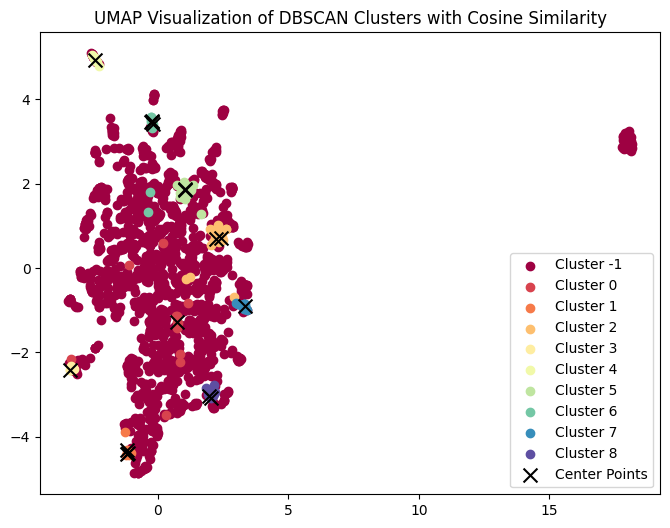

In [ ]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import DBSCAN

#2 DBSCAN Clustering
from sklearn.cluster import DBSCAN

# DBSCAN 모델의 파라미터 조정
model = DBSCAN(eps=0.6, min_samples=12, metric="cosine")
result = model.fit_predict(vector)
df['result'] = result

# UMAP을 사용하여 데이터를 2차원으로 변환
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_vector = umap_model.fit_transform(vector)

# 중심 포인트 가져오기
center_points = umap_vector[model.core_sample_indices_]

# 시각화
plt.figure(figsize=(8, 6))

unique_labels = np.unique(result)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    cluster_points = umap_vector[result == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i], label=f'Cluster {label}')

# 중심 포인트 표시
plt.scatter(center_points[:, 0], center_points[:, 1], color='black', marker='x', s=100, label='Center Points')

plt.title('UMAP Visualization of DBSCAN Clusters with Cosine Similarity')
plt.legend()
plt.show()



In [ ]:
model.core_sample_indices_

array([ 114,  363,  376,  453,  469,  639,  645,  759,  950, 1100, 1177,
       1313, 1347, 1356, 1363, 1440, 1494])

In [ ]:
df['title_p'][[114,  363,  376,  453,  469,  639,  645,  759,  950, 1100, 1177,
       1313, 1347, 1356, 1363, 1440, 1494]]

114     얼마예요 단 3초 만에 나비 꽃 모양 몸에 새겼다 한소희도 푹빠진 타투 정체는
363          한은 기준금리 4연속 동결 2퍼센트p 금리차 부담 속 경기 집중 상보
376      한은, 3.5퍼센트 기준금리 4연속 동결 한 미 금리차 2퍼센트p 임박 상보
453                    삼성전자, 미브로드컴에 시가총액 잡혀 반도체 4위로
469             신동원 농심 회장 취임 2주년 2030년 미 라면시장 1위 목표
639                   로또 조작 불가능 통계적으로 1 2등 다수 당첨 가능
645                            단독 코람코, 마제스타 타워1 품는다
759             한은, 기준금리 4연속 동결 미국과 초유의 2퍼센트P 차이 눈앞
950                             탈통신 SKT 신무기는 AI UAM
1100                삼성 LG, 4000만원대 TV 동시출격 프리미엄 대격돌
1177            AI 챗봇 뒤 팩트검증 노동자들의 그림자 과로 낮은 급여 시달려
1313              최저임금 오르면 직업훈련 선거보조원 수당까지 200개 줄인상
1347              노동계 1만1040원 경영계 9755원 최저임금 5차 수정안
1356                    잃어버린 30년 되찾겠다 일, 반도체 재건에 사활
1363               자동차가 갓 나와 교통사고 났을 때 빌게이츠의 AI 낙관론
1440                         단독 고용률 역대급 인데 못 웃는 부산시
1494                    척 보면 알아요, 맛있는 거봉 쏙쏙 골라내는 AI
Name: title_p, dtype: object

# VII. 대주제 생성-KeyBERT

In [ ]:
pip install keybert

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.8 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23776 sha256=8b8b073ad707b2c7bdd3fbbf2d89487386ff5d238a9c0fb84cda88be3bb26d4f
  Stored in directory: /root/.cache/pip/wheels/66/8d/e6/b0e2f8d883b0fd51819226f67ad9843e04913ce4a97241ff4b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=459c645be8066d9ac03b1ca8279b625ae745d9eac5d9ac9018610a929f46fd8f
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keybert import KeyBERT

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/title_dbscan_은정.xlsx")

In [ ]:
df.rename(columns={'result':'cluster_num'}, inplace=True)
df

,date,title_p,content_p,len,New_keys,New_collocation,merged_col,final_key,final_key_10,final_key_11,final_key_12,cluster_num,title,content
0,2023-07-13 06:01:30,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"['민간임대주택', '집단', '특별법', '임대', '임대보증금', '가입요건',...","['민간임대주택', '등록', '보험가입', '임대보증금보증', '특별법시행', '...","['특별법시행', '가입요건', '보증보험가입', '전세보증금', '등록', '보험...",NaN,"['공시가격', '임대', '집단', '보험가입', '등록', '전세보증금', '보...","['보증금반환보증', '공시가격', '임대', '집단', '보험가입', '등록', ...","['임대사업자', '보증금반환보증', '공시가격', '임대', '집단', '보험가입...",-1,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령..."
1,2023-07-13 06:01:32,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",['제로슈거'],"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",NaN,"['제로슈거', '혼란', '열량', '식품회사', '발암', '도수', '다이어트...","['말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암', '도수'...","['제로', '말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암'...",-1,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...
2,2023-07-13 06:01:33,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"['수요', '월세', '주택', '아파트', '임대', '서울', '대출', '전...","['월세가격', '퍼센트', '전세대출금리', '서울아파트', '대출규제', '지난...","['수요', '서울', '대출규제', '평균월세', '립다세대', '임대수요', '...",NaN,"['임대', '아파트', '대출금리', '임대수요', '립다세대', '평균월세', ...","['전세대출금리', '임대', '아파트', '대출금리', '임대수요', '립다세대'...","['대출', '전세대출금리', '임대', '아파트', '대출금리', '임대수요', ...",-1,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...
3,2023-07-13 06:02:01,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"['25bp', '마켓pro', '소비자물가', '방향성', '입장', '금리인상'...","['금리인상', '소비자물가', '마켓PRO']","['가운데', '25bp', '마켓pro', '소비자물가', '입장', '방향성',...",NaN,"['마켓PRO', '가운데', '25bp', '소비자물가', '입장', '방향성',...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...",-1,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",['한국거래소'],"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",NaN,"['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...",0,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"['청구', '10bp', '금리', '실업보험', '투자자', '기업', '불러드...","['실업보험', '보험청구', '퍼센트상승', '500지수', '생산자물가', '예...","['청구', '실업보험', '생산자물가', '주간', '전달', '전장', '10b...",NaN,"['실업보험청구', '시즌', '10bp', '전장', '전달', '주간', '생산...","['보험청구', '실업보험청구', '시즌', '10bp', '전장', '전달', '...","['예상', '보험청구', '실업보험청구', '시즌', '10bp', '전장', '...",-1,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"['보험연구원', '손해보험사', '보험사', '이익', '생명보험사', 'csm'...","['손해보험사', '보험연구원', 'IFRS17', '손해보험', '수입보험료']","['손해보험사', '보험연구원', 'IFRS17', '이익', '보험사', '생명보...",NaN,"['이익', '보험사', '생명보험사', '손해보험', 'csm', '수입보험료',...","['IFRS17', '이익', '보험사', '생명보험사', '손해보험', 'csm'...","['보험연구원', 'IFRS17', '이익', '보험사', '생명보험사', '손해보...",-1,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...
1570,2023-07-14 05:46:01,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"['개선', '지난해', '김진태', '부지', '적자', '기업', '김유진', ...","['신임대표', '실적개선', '레이', '기업가치', 'IMMPE']","['신임대표', '개선', '실적개선', '김진태', '부지', '레이', '적자'...",NaN,"['imm', '김유진', '적자'

In [ ]:
# 키워드 클러스터링 군집 1개 추가: 클러스터 번호 9번
df.loc[[ 791,  810,  822,  884,  890,  925,  939,  977,  981,  997, 1031,
            1060, 1066, 1068, 1106, 1224, 1291, 1294, 1572], 'cluster_num'] = 9


In [ ]:
#df.to_excel('final dataset.xlsx')

In [ ]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 41.5 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
####여기 돌리면 됨!
## title로 한단어~두단어 키워드 출력
# 희재수정
for i in range(1,10):
    dff = df[df['cluster_num']==i]['title']
    dff = ' '.join(dff)
    morphemes = okt.pos(dff)
    filtered_words = [word for word, pos in morphemes if pos in ['Noun', 'Number', 'Alpha', 'Suffix']]
    filtered_words = ' '.join(filtered_words)
    kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')
    keywords = kw_model.extract_keywords(filtered_words,
                                    keyphrase_ngram_range=(1,2),
                                    use_maxsum=True,
                                    nr_candidates = 20,
                                    top_n = 3,
                                    use_mmr = True,
                                    diversity=0.7)
    print(keywords)
    result = []
    result.append(keywords)

[('금리 역대', 0.7091), ('미국 다른', 0.4164), ('회복', 0.1713)]
[('반도체 교실', 0.6628), ('대한민국 저력', 0.4274), ('회복 1년', 0.2534)]
[('회장 2030년', 0.711), ('매출 성장', 0.3287), ('열풍', 0.13)]
[('당첨 음모론', 0.6343), ('조작 정부', 0.4512), ('2등 600', 0.28)]
[('금융위 금감원', 0.6453), ('언어 모델', 0.3387), ('유튜버 스태프', 0.2117)]
[('총장 ai', 0.5314), ('cfo lounge', 0.2488), ('교통사고', 0.0678)]
[('출시 삼성', 0.6766), ('vs lg', 0.393), ('tv 경쟁', 0.318)]
[('최저임금 10620원', 0.7455), ('선거 보조', 0.2004), ('폭풍', 0.081)]
[('경제 불안', 0.64), ('gdp 대비', 0.2572), ('발목 이창용', 0.0392)]


In [ ]:
import re

In [ ]:
# 필요없는 부분
def filter_words(text):
    return re.findall(r'[가-힣a-zA-Z0-9]+', text)

# Perform morphological analysis on each word within the lists and filter desired words
filtered_lists = []
for sublist in result:
    filtered_sublist = [(filter_words(word), score) for word, score in sublist]
    filtered_lists.append(filtered_sublist)

# Print the resulting filtered lists
for sublist in filtered_lists:
    print(sublist)


[(['우리경제', '불안'], 0.7027), (['이창용', '구조개혁'], 0.4149), (['gdp'], 0.1725)]


In [ ]:
####여기 돌리면 됨!
## title로 한단어 키워드 출력

# 여기도 희재 수정
for i in range(1,10):
    dff = df[df['cluster_num']==i]['title']
    dff = ' '.join(dff)
    morphemes = okt.pos(dff)
    filtered_words = [word for word, pos in morphemes if pos in ['Noun', 'Number', 'Alpha', 'Suffix']]
    filtered_words = ' '.join(filtered_words)

    kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')
    keywords = kw_model.extract_keywords(filtered_words,
                                    keyphrase_ngram_range=(1,1),
                                    use_maxsum=True,
                                    nr_candidates = 20,
                                    top_n = 3,
                                    use_mmr = True,
                                    diversity=0.7)
    print(keywords)
    result = []
    result.append(keywords)

[('금리', 0.5982), ('미국', 0.3777), ('회복', 0.1713)]
[('반도체', 0.5145), ('대한민국', 0.45), ('개월', 0.2508)]
[('2030년', 0.671), ('회장', 0.3923), ('성장', 0.3344)]
[('확률', 0.4953), ('티켓', 0.3452), ('정부', 0.293)]
[('금융위', 0.544), ('유튜버', 0.2098), ('근로자', 0.1988)]
[('총장', 0.4899), ('lounge', 0.2161), ('교통사고', 0.0678)]
[('삼성', 0.5762), ('거거익선', 0.3584), ('tv', 0.3296)]
[('최저임금', 0.6249), ('1040원', 0.4197), ('폭풍', 0.081)]
[('경제', 0.503), ('걱정', 0.3735), ('gdp', 0.1726)]


In [ ]:
# 여기 아래는 안쓴 부분 -희재

In [ ]:
filtered_words

['이창용',
 '성장',
 '률',
 '경제',
 '순위',
 '문제',
 '구조',
 '개혁',
 '필요',
 '이창용',
 '저출산',
 '고령화',
 '경쟁력',
 '둔화',
 '더',
 '문제',
 '종합',
 '이창용',
 '가계부채',
 '예상',
 '밖',
 '증',
 '가시',
 '금리',
 '등',
 '통해',
 '대응',
 '종합',
 '이창용',
 '경제',
 '규모',
 '13',
 '위',
 '구조',
 '개혁',
 '순위',
 '더',
 '걱정',
 '이창용',
 '가계부채',
 '우려',
 'GDP',
 '대비',
 '비율',
 '우리',
 '경제',
 '불안',
 '요소',
 '일문일답',
 '일문일답',
 '이창용',
 '가계부채',
 '늘',
 '금리',
 '대응',
 '인하',
 '논의',
 '이창용',
 '금통위',
 '원',
 '모두',
 '기준금리',
 '3.75%',
 '가능성',
 '왜',
 '일문일답',
 '이창용',
 '새마을금고',
 '사태',
 '업',
 '권',
 '개별',
 '기관',
 '문제',
 '정책',
 '축',
 '이창용',
 '가계부채',
 '우려',
 'GDP',
 '대비',
 '80%',
 '수준',
 '이창용',
 '은',
 '총재',
 '금통위',
 '원',
 '전원',
 '최종',
 '금리',
 '3.75%',
 '가능성',
 '은',
 '총재',
 '물가',
 '미국',
 '금리',
 '가계부채',
 '금리',
 '인상',
 '옵션',
 '일문일답',
 '이창용',
 '가계부채',
 '증가',
 '세',
 '우려',
 '통화정책',
 '중요',
 '목표',
 '생각',
 '대응',
 '것',
 '이창용',
 '새마을금고',
 '상황',
 '안정',
 '중앙회',
 '유동성',
 '공급',
 '게',
 '은',
 '역할',
 '일문일답',
 '이창용',
 '새마을금고',
 '사태',
 '업계',
 '개별',
 '기관',
 '문제',
 '연체',
 '율',
 '위기',
 '기준금리',
 

In [ ]:
#### 수정 하지 마세용
## title_p로 키워드 한단어~두단어 출력
for i in range(1,10):
    dff = df[df['cluster_num']==i]['title_p']
    dff = ' '.join(dff)
    kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')
    keywords = kw_model.extract_keywords(dff,
                                    keyphrase_ngram_range=(1,2),
                                    use_maxsum=True,
                                    nr_candidates = 20,
                                    top_n = 3,
                                    use_mmr = True,
                                    diversity=0.7)
    print(keywords)
    result = []
    result.append(keywords)

[('금리차 역대', 0.7962), ('4연속 동결', 0.3192), ('회복', 0.0393)]
[('반도체 교실', 0.7509), ('업계는 회의적', 0.325), ('회복은 1년', 0.2508)]
[('회장 2030년', 0.7706), ('매출 3배', 0.3954), ('열풍', 0.1511)]
[('당첨 확률상', 0.6158), ('불가능하다', 0.434), ('정부 근거는', 0.3861)]
[('금융위로 금감원', 0.7089), ('1000억 한미약품', 0.4066), ('유튜버 스태프', 0.3318)]
[('총장 ai', 0.5281), ('챗봇 팩트검증', 0.332), ('교통사고', 0.0229)]
[('거거익선 삼성', 0.6927), ('tv 수신료', 0.4258), ('전쟁', 0.045)]
[('1만원 넘을지가', 0.8222), ('42퍼센트 최저임금', 0.2123), ('직업훈련 선거보조원', 0.0335)]
[('연체율 위기가', 0.691), ('한국은행 이창용', 0.1166), ('논의 없다', 0.112)]


In [ ]:
#### 수정 하지 마세용
## title_p로 키워드 한단어만 출력
for i in range(1,10):
    dff = df[df['cluster_num']==i]['title_p']
    dff = ' '.join(dff)
    kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')
    keywords = kw_model.extract_keywords(dff,
                                    keyphrase_ngram_range=(1,1),
                                    use_maxsum=True,
                                    nr_candidates = 20,
                                    top_n = 3,
                                    use_mmr = True,
                                    diversity=0.7)
    print(keywords)
    result = []
    result.append(keywords)

[('금리차', 0.7465), ('미국과', 0.1356), ('회복', 0.0393)]
[('반도체', 0.5959), ('교실', 0.4508), ('6개월', 0.2398)]
[('2030년까지', 0.7187), ('15억달러', 0.4158), ('꺾고', 0.2423)]
[('불가능', 0.4442), ('티켓', 0.3112), ('600명', 0.2017)]
[('하나금융', 0.6113), ('유튜버', 0.3281), ('근로자', 0.1196)]
[('총장', 0.4752), ('lounge', 0.044), ('교통사고', 0.0229)]
[('삼성', 0.562), ('tv', 0.3456), ('클수록', 0.206)]
[('결정난다', 0.7239), ('7퍼센트', 0.2949), ('최저임금', 0.2263)]
[('한경제규모', 0.5913), ('아닌', 0.1771), ('gdp', 0.1108)]


In [ ]:
dff = df[df['cluster_num']==1]['title_p']
dff

206     한은 금통위 긴급 예측 기준금리 4연속 동결 유력 정철진 경제평론가 머니 클라스
363           한은 기준금리 4연속 동결 2퍼센트p 금리차 부담 속 경기 집중 상보
376       한은, 3.5퍼센트 기준금리 4연속 동결 한 미 금리차 2퍼센트p 임박 상보
411                       금통위, 금융 불안에 기준금리 4연속 동결 상보
422            새마을금고도 불안한데 한은, 기준금리 3.5퍼센트 4연속 동결 상보
510                    금리차 2퍼센트P 임박 한은, 미국과 다른 길 택했다
588                        기준금리 4연속 동결 경기 회복 지켜본다 종합
759              한은, 기준금리 4연속 동결 미국과 초유의 2퍼센트P 차이 눈앞
1186            한은 기준금리 4연속 동결, 이달 한미금리차 2퍼센트p 확대 전망
1220                     한은 기준금리 4연속 동결에도 꿈틀대는 대출 금리
1364     한은, 기준금리 3.5퍼센트 4연속 동결 미와 사상최대 2퍼센트p 차 벌어지나
1413         한은, 기준금리 4연속 동결 한 미 금리차 역대 최대 눈앞 뉴스 투데이
1502                       기준금리 4연속 동결 한은, 3.5퍼센트 유지
Name: title_p, dtype: object

In [ ]:
dff = ','.join(dff)
dff

'한은 금통위 긴급 예측 기준금리 4연속 동결 유력 정철진 경제평론가 머니 클라스,한은 기준금리 4연속 동결 2퍼센트p 금리차 부담 속 경기 집중 상보,한은, 3.5퍼센트 기준금리 4연속 동결 한 미 금리차 2퍼센트p 임박 상보,금통위, 금융 불안에 기준금리 4연속 동결 상보,새마을금고도 불안한데 한은, 기준금리 3.5퍼센트 4연속 동결 상보,금리차 2퍼센트P 임박 한은, 미국과 다른 길 택했다,기준금리 4연속 동결 경기 회복 지켜본다 종합,한은, 기준금리 4연속 동결 미국과 초유의 2퍼센트P 차이 눈앞,한은 기준금리 4연속 동결, 이달 한미금리차 2퍼센트p 확대 전망,한은 기준금리 4연속 동결에도 꿈틀대는 대출 금리,한은, 기준금리 3.5퍼센트 4연속 동결 미와 사상최대 2퍼센트p 차 벌어지나,한은, 기준금리 4연속 동결 한 미 금리차 역대 최대 눈앞 뉴스 투데이,기준금리 4연속 동결 한은, 3.5퍼센트 유지'

In [ ]:
#kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')

doc = """
한은 금통위 긴급 예측! 기준금리 4연속 동결 유력 (정철진 경제평론가)｜머니 클라스 한은 기준금리 4연속 동결…\'2%p 금리차\' 부담 속 경기 집중(상보) 한국은행, 기준금리 연 3.5%로 4연속 동결 한은, 3.5% 기준금리 4연속 동결… 한·미 금리차 2%p 임박(상보) 금통위, 금융 불안에 기준금리 4연속 동결(상보) 새마을금고도 불안한데…한은, 기준금리 \'3.5%\' 4연속 동결(상보) 4연속 동결 선택한 한은…불확실한 경기에 시장선 "연내 인하 가능성" 기준금리 4연속 동결…경기 회복 지켜본다(종합) 한은, 기준금리 4연속 동결… 미국과 초유의 ‘2%P 차이’ 눈앞 기준금리 3.5%로 동결‥"경기 위축 부담" 기준금리 4연속 묶었다…한은, 수출·경기 고려 3.50% 동결 기준금리 3.5%로 동결‥"경기 위축 부담" 한은 기준금리 4연속 동결, 이달 한미금리차 2%p 확대 전망 한은 기준금리 4연속 동결에도 꿈틀대는 대출 금리 기준금리 4연속 동결한 한국은행…이창용 "부동산 연착륙 필요" 한은, 기준금리 3.5% ‘4연속 동결’...美와 사상최대 2%p 차 벌어지나 韓銀, 기준금리 4연속 동결… 韓·美 금리차 역대 최대 눈앞 [뉴스 투데이] 기준금리 4연속 동결… 한은, 3.5% 유지
"""
#keywords = kw_model.extract_keywords(dff,
                                   # keyphrase_ngram_range=(1,2),
                                   # use_maxsum=True,
                                   # nr_candidates = 20,
                                   # top_n = 3,
                                   # use_mmr = True,
                                  #  diversity=0.7)

In [ ]:
keywords

[('금리차 역대', 0.7962), ('4연속 동결', 0.3192), ('회복', 0.0393)]

In [ ]:
doc

'\n한은 금통위 긴급 예측! 기준금리 4연속 동결 유력 (정철진 경제평론가)｜머니 클라스 한은 기준금리 4연속 동결…\'2%p 금리차\' 부담 속 경기 집중(상보) 한국은행, 기준금리 연 3.5%로 4연속 동결 한은, 3.5% 기준금리 4연속 동결… 한·미 금리차 2%p 임박(상보) 금통위, 금융 불안에 기준금리 4연속 동결(상보) 새마을금고도 불안한데…한은, 기준금리 \'3.5%\' 4연속 동결(상보) 4연속 동결 선택한 한은…불확실한 경기에 시장선 "연내 인하 가능성" 기준금리 4연속 동결…경기 회복 지켜본다(종합) 한은, 기준금리 4연속 동결… 미국과 초유의 ‘2%P 차이’ 눈앞 기준금리 3.5%로 동결‥"경기 위축 부담" 기준금리 4연속 묶었다…한은, 수출·경기 고려 3.50% 동결 기준금리 3.5%로 동결‥"경기 위축 부담" 한은 기준금리 4연속 동결, 이달 한미금리차 2%p 확대 전망 한은 기준금리 4연속 동결에도 꿈틀대는 대출 금리 기준금리 4연속 동결한 한국은행…이창용 "부동산 연착륙 필요" 한은, 기준금리 3.5% ‘4연속 동결’...美와 사상최대 2%p 차 벌어지나 韓銀, 기준금리 4연속 동결… 韓·美 금리차 역대 최대 눈앞 [뉴스 투데이] 기준금리 4연속 동결… 한은, 3.5% 유지\n'

# VIII. 기사 요약-KoBART

In [ ]:
import pandas as pd
import numpy as np

C:\Users\82103\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\82103\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\82103\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
df = pd.read_excel('C:/Users/82103/Downloads/final dataset.xlsx')
df2 = pd.read_excel('C:/Users/82103/Downloads/news_summary.xlsx')

In [ ]:
df

,Unnamed: 0,date,title_p,content_p,len,New_keys,New_collocation,merged_col,final_key,final_key_10,final_key_11,final_key_12,cluster_num
0,0,2023-07-13 06:01:30,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"['민간임대주택', '집단', '특별법', '임대', '임대보증금', '가입요건',...","['민간임대주택', '등록', '보험가입', '임대보증금보증', '특별법시행', '...","['특별법시행', '가입요건', '보증보험가입', '전세보증금', '등록', '보험...",NaN,"['공시가격', '임대', '집단', '보험가입', '등록', '전세보증금', '보...","['보증금반환보증', '공시가격', '임대', '집단', '보험가입', '등록', ...","['임대사업자', '보증금반환보증', '공시가격', '임대', '집단', '보험가입...",-1
1,1,2023-07-13 06:01:32,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",['제로슈거'],"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",NaN,"['제로슈거', '혼란', '열량', '식품회사', '발암', '도수', '다이어트...","['말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암', '도수'...","['제로', '말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암'...",-1
2,2,2023-07-13 06:01:33,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"['수요', '월세', '주택', '아파트', '임대', '서울', '대출', '전...","['월세가격', '퍼센트', '전세대출금리', '서울아파트', '대출규제', '지난...","['수요', '서울', '대출규제', '평균월세', '립다세대', '임대수요', '...",NaN,"['임대', '아파트', '대출금리', '임대수요', '립다세대', '평균월세', ...","['전세대출금리', '임대', '아파트', '대출금리', '임대수요', '립다세대'...","['대출', '전세대출금리', '임대', '아파트', '대출금리', '임대수요', ...",-1
3,3,2023-07-13 06:02:01,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"['25bp', '마켓pro', '소비자물가', '방향성', '입장', '금리인상'...","['금리인상', '소비자물가', '마켓PRO']","['가운데', '25bp', '마켓pro', '소비자물가', '입장', '방향성',...",NaN,"['마켓PRO', '가운데', '25bp', '소비자물가', '입장', '방향성',...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...",-1
4,4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",['한국거래소'],"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",NaN,"['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"['청구', '10bp', '금리', '실업보험', '투자자', '기업', '불러드...","['실업보험', '보험청구', '퍼센트상승', '500지수', '생산자물가', '예...","['청구', '실업보험', '생산자물가', '주간', '전달', '전장', '10b...",NaN,"['실업보험청구', '시즌', '10bp', '전장', '전달', '주간', '생산...","['보험청구', '실업보험청구', '시즌', '10bp', '전장', '전달', '...","['예상', '보험청구', '실업보험청구', '시즌', '10bp', '전장', '...",-1
1569,1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"['보험연구원', '손해보험사', '보험사', '이익', '생명보험사', 'csm'...","['손해보험사', '보험연구원', 'IFRS17', '손해보험', '수입보험료']","['손해보험사', '보험연구원', 'IFRS17', '이익', '보험사', '생명보...",NaN,"['이익', '보험사', '생명보험사', '손해보험', 'csm', '수입보험료',...","['IFRS17', '이익', '보험사', '생명보험사', '손해보험', 'csm'...","['보험연구원', 'IFRS17', '이익', '보험사', '생명보험사', '손해보...",-1
1570,1570,2023-07-14 05:46:01,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"['개선', '지난해', '김진태', '부지', '적자', '기업', '김유진', ...","['신임대표', '실적개선', '레이', '기업가치', 'IMMPE']","['신임대표', '개선', '실적개선', '김진태', '부지', '레이', '적자'...",NaN,"['imm', '김유진', '적자', '레이', '부지', '김진태', '실적개선'...","['기업가치', 'imm', '김유진', '적자', '레이', '부지', '김진태'...","['pe', '기업가치', 'imm', '김유진', '적자', '레이', '부지',...",-1
1571,1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승 엔비디아 4.7퍼센트",파이낸셜뉴스 뉴욕증시가 13일 이하 현지시간 대형 기술주 강세 속에 상승세를 이어갔...,1941,"['전날', '시장', '일비', '아마존', '알파벳', '상승', '미래', '...","['퍼센트오른', '퍼센트상승', '물가지수', '예상', '금리인상', '시장예상...","['아마존', '미래', '금리인상', '퍼센트급등', '일비', '알파벳', '상...",NaN,"['물가지수', '시장예상', 'ppi', '알파벳', '일비', '퍼센트급등', ...","['로웬가트', '물가지수', '시장예상', 'ppi', '알파벳', '일비', '...","['프라임데이', '로웬가트', '물가지수', '시장예상', 'ppi', '알파벳'...",-1


In [ ]:
df2 = df2.drop(['Unnamed: 0.1'], axis=1)
df2 = df2.drop(['Unnamed: 0'], axis=1)

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
df['summary'] = df2['summary']

In [ ]:
df

,date,title_p,content_p,len,New_keys,New_collocation,merged_col,final_key,final_key_10,final_key_11,final_key_12,cluster_num,summary
0,2023-07-13 06:01:30,"차라리 자진 말소하겠다 임대인들, 보증보험 요건 강화 명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126퍼센트 강화 민간임대 특별법 시...",2081,"['민간임대주택', '집단', '특별법', '임대', '임대보증금', '가입요건',...","['민간임대주택', '등록', '보험가입', '임대보증금보증', '특별법시행', '...","['특별법시행', '가입요건', '보증보험가입', '전세보증금', '등록', '보험...",NaN,"['공시가격', '임대', '집단', '보험가입', '등록', '전세보증금', '보...","['보증금반환보증', '공시가격', '임대', '집단', '보험가입', '등록', ...","['임대사업자', '보증금반환보증', '공시가격', '임대', '집단', '보험가입...",-1,13토부는 임대보증금 미반환으로 등록 말소된 등록임대사업자 정보를 온라인에 공개하는...
1,2023-07-13 06:01:32,단맛의 세계 칼로리 안 낮은데 믿었던 제로 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로 이하 새로 는 ...,1901,"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",['제로슈거'],"['말티톨', '제로', '제로슈거', '혼란', '열량', '식품회사', '발암'...",NaN,"['제로슈거', '혼란', '열량', '식품회사', '발암', '도수', '다이어트...","['말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암', '도수'...","['제로', '말티톨', '제로슈거', '혼란', '열량', '식품회사', '발암'...",-1,작당당 열량이 4kcal 미만일 때 사용할 수 있는 제로 설탕 음료는 '살이 덜 찐...
2,2023-07-13 06:01:33,전세 사기보다 치솟은 월세가 더 무섭다 월세 수요 한풀 꺾여,6월 기준 서울 전세비중 51퍼센트대 회복 월세 급등에 전세로 선회 전세대출 금리 ...,1850,"['수요', '월세', '주택', '아파트', '임대', '서울', '대출', '전...","['월세가격', '퍼센트', '전세대출금리', '서울아파트', '대출규제', '지난...","['수요', '서울', '대출규제', '평균월세', '립다세대', '임대수요', '...",NaN,"['임대', '아파트', '대출금리', '임대수요', '립다세대', '평균월세', ...","['전세대출금리', '임대', '아파트', '대출금리', '임대수요', '립다세대'...","['대출', '전세대출금리', '임대', '아파트', '대출금리', '임대수요', ...",-1,최근법원 등기정보광장에 따르면 지난 6월 확정일자를 받은 전국 주거시설 21만299...
3,2023-07-13 06:02:01,마켓PRO 칼럼 셈법 복잡해진 한국은행 금통위,한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수 ...,1802,"['25bp', '마켓pro', '소비자물가', '방향성', '입장', '금리인상'...","['금리인상', '소비자물가', '마켓PRO']","['가운데', '25bp', '마켓pro', '소비자물가', '입장', '방향성',...",NaN,"['마켓PRO', '가운데', '25bp', '소비자물가', '입장', '방향성',...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...","['마켓pro', '마켓PRO', '가운데', '25bp', '소비자물가', '입장...",-1,"최근 원-원 환율이 1,300원을 중심으로 좀처럼 방향성을 잡지 못하고 제자리를 맴..."
4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양 시장서는 이게 맞아,8거래일간 100퍼센트 넘게 뛰다 12일 10퍼센트대 급락 시총 6조 근접 한국항공...,1645,"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",['한국거래소'],"['금양은', '발포', '한국항공우주', '급등', '공매도', '원통형', '6...",NaN,"['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...","['금양', '금양은', '발포', '한국항공우주', '급등', '공매도', '원통...",0,일일 만에 주가가 두 배로 오른 금양(001570)을 두고 장기적인 성장 가능성을 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승 S&P500 4,500 돌파 마감",뉴욕 연합뉴스 윤영숙 연합인포맥스 특파원 뉴욕증시는 소비자 물가에 이어 생산자 물가...,2442,"['청구', '10bp', '금리', '실업보험', '투자자', '기업', '불러드...","['실업보험', '보험청구', '퍼센트상승', '500지수', '생산자물가', '예...","['청구', '실업보험', '생산자물가', '주간', '전달', '전장', '10b...",NaN,"['실업보험청구', '시즌', '10bp', '전장', '전달', '주간', '생산...","['보험청구', '실업보험청구', '시즌', '10bp', '전장', '전달', '...","['예상', '보험청구', '실업보험청구', '시즌', '10bp', '전장', '...",-1,뉴욕증시는 소비자 물가에 이어 생산자 물가도 둔화 조짐을 보이고 있다는 소식에 상승...
1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다 보험권 희비교차",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,1358,"['보험연구원', '손해보험사', '보험사', '이익', '생명보험사', 'csm'...","['손해보험사', '보험연구원', 'IFRS17', '손해보험', '수입보험료']","['손해보험사', '보험연구원', 'IFRS17', '이익', '보험사', '생명보...",NaN,"['이익', '보험사', '생명보험사', '손해보험', 'csm', '수입보험료',...","['IFRS17', '이익', '보험사', '생명보험사', '손해보험', 'csm'...","['보험연구원', 'IFRS17', '이익', '보험사', '생명보험사', '손해보...",-1,14일 보험연구원에 따르면 올해 손해보험사들의 수입보험료는 125조4000억원으로 ...
1570,2023-07-14 05:46:01,"어쩌다 이렇게까지 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자 수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,1886,"['개선', '지난해', '김진태', '부지', '적자', '기업', '김유진', ...","['신임대표', '실적개선', '레이', '기업가치', 'IMMPE']","['신임대표', '개선', '실적개선', '김진태', '부지', '레이', '적자'...",NaN,"['imm', '김유진', '적자', '레이', '부지', '김진태', '실적개선'...","['기업가치', 'imm', '김유진', '적자', '레이', '부지', '김진태'...","['pe', '기업가치', 'imm', '김유진', '적자', '레이', '부지',...",-1,가구샘은 13일 이사회를 열고 김유진 IMM오퍼레이션즈 본부장을 신임대표로 선임해 ...
1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승 엔비디아 4.7퍼센트",파이낸셜뉴스 뉴욕증시가 13일 이하 

In [ ]:
import torch
from transformers import PreTrainedTokenizerFast
from transformers import BartForConditionalGeneration

#tokenizer = PreTrainedTokenizerFast.from_pretrained('digit82/kobart-summarization')
#model = BartForConditionalGeneration.from_pretrained('digit82/kobart-summarization')

In [ ]:
text = cont.replace('\n', ' ')

raw_input_ids = tokenizer.encode(text)
input_ids = [tokenizer.bos_token_id] + raw_input_ids + [tokenizer.eos_token_id]

summary_ids = model.generate(torch.tensor([input_ids]),  num_beams=4,  max_length=512,  eos_token_id=1)
tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)


"지난 3월28일 국회 본회의를 통과한 '민간임대주택에 관한 특별법' 개정안에 따르면 정부가 보증금 미반환 임대인 명단을 공개하기로 한 데 이어 임대사업자들이 반드시 가입해야 하는 임대보증금 보증보험 가입요건 강화를 앞두고 있는 등 전세사기 예방 대책을 속속 내놓고 있는 가운데, 임대인들이 크게 반발하고 있어 진통이 예상된다."

In [ ]:
data['summary']=None

In [ ]:
# 계산수가 너무 복잡
for i in range(len(news_lst)):
  # 뉴스요약

    tokenizer =  PreTrainedTokenizerFast.from_pretrained("ainize/kobart-news")
    model = BartForConditionalGeneration.from_pretrained("ainize/kobart-news")

    inputs_ids = tokenizer.encode(data['content'][i], return_tensors="pt")

# kobert가 정해둔 데이터 크기의 한계가 있어서 텍스트가 긴 뉴스같은 경우는 잘라야할듯
# 모델 입력 최대값 구하는 코드
    max_input_length = model.config.max_position_embeddings

    inputs_ids = inputs_ids[:, :max_input_length]

    summary_text_ids = model.generate(
        input_ids = inputs_ids,
        bos_token_id = model.config.bos_token_id,
        eos_token_id = model.config.eos_token_id,
        length_penalty = 2.0,
        max_length = 128,
        min_length = 32,
        num_beams = 4)
  # 요약한 값을 summary라는 새 열에 저장
  # summary_text_ids[0]가 맞음 i 아님
    #data['summary'][i] = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
    tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
      # 키워드 추출
      #nouns = okt.nouns(df2['content'][i])
      #text = ' '.join(nouns)
      #keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words=None, top_n=10)

    # 데이터프레임에 키워드 할당
      #df2.at[i, 'keywords'] = keywords

C:\Users\82103\AppData\Local\Temp/ipykernel_20428/326131177.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['summary'][i] = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
C:\Users\82103\AppData\Local\Temp/ipykernel_20428/326131177.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['summary'][i] = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
C:\Users\82103\AppData\Local\Temp/ipykernel_20428/326131177.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
data

,Unnamed: 0,date,title,content,press,link,summary
0,0,2023-07-13 06:01:30,"""차라리 자진 말소하겠다""...임대인들, 보증보험 요건 강화·명단 공개에 반발","국토부, 7월 중 임대보증금 보증보험 가입요건 126% 강화 민간임대 특별법 시행령...",뉴시스,https://n.news.naver.com/mnews/article/003/001...,13토부는 임대보증금 미반환으로 등록 말소된 등록임대사업자 정보를 온라인에 공개하는...
1,1,2023-07-13 06:01:32,[단맛의 세계]② “칼로리 안 낮은데?” 믿었던 ‘제로’ 마케팅의 배신,작년 9월 출시 후 선풍적인 인기를 끈 롯데칠성음료의 처음처럼 새로(이하 새로)는 ...,조선비즈,https://n.news.naver.com/mnews/article/366/000...,작당당 열량이 4kcal 미만일 때 사용할 수 있는 제로 설탕 음료는 '살이 덜 찐...
2,2,2023-07-13 06:01:33,"""전세 사기보다 치솟은 월세가 더 무섭다""…월세 수요 한풀 꺾여",6월 기준 서울 전세비중 51%대 회복…월세 급등에 전세로 선회 전세대출 금리 3%...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,최근법원 등기정보광장에 따르면 지난 6월 확정일자를 받은 전국 주거시설 21만299...
3,3,2023-07-13 06:02:01,[마켓PRO 칼럼] 셈법 복잡해진 한국은행 금통위,※한경 마켓PRO 텔레그램을 구독하시면 프리미엄 투자 콘텐츠를 보다 편리하게 볼 수...,한국경제,https://n.news.naver.com/mnews/article/015/000...,"최근 원-원 환율이 1,300원을 중심으로 좀처럼 방향성을 잡지 못하고 제자리를 맴..."
4,4,2023-07-13 06:02:01,일주일 만에 두 배 뛴 금양…시장서는 ‘이게 맞아?’,8거래일간 100% 넘게 뛰다 12일 10%대 급락 시총 6兆 근접…한국항공우주·L...,이데일리,https://n.news.naver.com/mnews/article/018/000...,일일 만에 주가가 두 배로 오른 금양(001570)을 두고 장기적인 성장 가능성을 ...
...,...,...,...,...,...,...,...
1568,1568,2023-07-14 05:41:58,"뉴욕증시, 인플레 완화에 상승…S&P500 4,500 돌파 마감",(뉴욕=연합뉴스) 윤영숙 연합인포맥스 특파원 = 뉴욕증시는 소비자 물가에 이어 생산...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...,뉴욕증시는 소비자 물가에 이어 생산자 물가도 둔화 조짐을 보이고 있다는 소식에 상승...
1569,1569,2023-07-14 05:43:00,"손보사 5.3조 더벌고, 생보사 7.2조 덜번다… 보험권 '희비교차'",올해 손해보험사와 생명보험사의 실적 희비가 엇갈릴 것이라는 보험연구원의 전망이 나왔...,머니S,https://n.news.naver.com/mnews/article/417/000...,14일 보험연구원에 따르면 올해 손해보험사들의 수입보험료는 125조4000억원으로 ...
1570,1570,2023-07-14 05:46:01,"""어쩌다 이렇게까지"" 한샘, 대표 교체로 쇄신 노린다",지난해 상장 이후 첫 적자…수익성 개선 노력했지만 성과 없어 IMM 경영에 적극 개...,아이뉴스24,https://n.news.naver.com/mnews/article/031/000...,가구샘은 13일 이사회를 열고 김유진 IMM오퍼레이션즈 본부장을 신임대표로 선임해 ...
1571,1571,2023-07-14 05:53:01,"뉴욕증시, 대형기술주 강세 속에 나흘 연속 상승...엔비디아 4.7%↑",[파이낸셜뉴스] 뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,뉴욕증시가 13일(이하 현지시간) 대형 기술주 강세 속에 상승세를 이어갔는데 이날 ...


In [ ]:
data.to_excel('news_summary.xlsx')

In [ ]:
dff = df[df['cluster_num']==1]
dfff = ' '.join(dff['summary'])
dfff

"J은행 금융통화위원회가 잠시 후 오전 9시, 회의를 열고 현재 3.50%인 기준금리를 조정할지 말지 결정하는데, 이번에도 동결하면 4번 연속 동결인데, 이렇게 될 것 같다는 전망이 우세하며, 이는 이미 역대 최대로 벌어진 한-미 금리 차이가 변수고, 정철진 경제평론가와 함께 오늘도 맥 한 번 짚어보겠습니다. 한일 금융통화위원회는 13일 오전 통화정책방향 결정회의에서 기준금리를 현행 연 3.50%로 유지해 지난 2월, 4월, 5월에 이은 4연속 동결했으며 한미 금리 격차가 이달 말 2%포인트(p)까지 벌어질 것으로 전망되나 2%대로 낮아진 물가 오름세와 아직은 확신할 수 없는 하반기 경기 회복을 고려한 결정으로 풀이된다. 한국은행 금융통화위원회가 13일 통화정책방향 결정회의를 열고 기준금리를 3.50%로 동결한 가운데 올 2월과 4월, 5월에 이어 이달까지 4회 연속 금리 동결로 한은의 금리 인상 사이클이 사실상 마무리되었다는 '인상 종결론'이 확실시 되고 있으며 미 연방준비제도(연준·Fed)는 오는 25~26일(현지 시각) 열리는 연방공개시장위원회(FOMC) 회의에서 금리 인상을 재개할 것이 유력시되고 시카고상품거래소(CME) 페드워치에 따르면 이날 오전 9시 기준 연방기금금리(FFR) 선물 시장에서 연준이 이달 베이비스텝(금리 13일 한국은행은 7월 금융통화위원회를 열고 새마을금고 사태 등에 따른 금융시장 불안을 이유로 기준금리를 4연속 동결했지만 '매파적(긴축 선호)' 스탠스는 유지할 것으로 보이며 다만 4연속 동결에도 '매파적' 스탠스는 유지할 것으로 보인다. 한국은행 금융통화위원회가 지난 2월, 4월, 5월에 이어 13일부터 기준금리를 연 3.5%로 동결했는데 물가 경로가 한은 예상대로 흘러가는 가운데 굳이 무리하게 금리를 올려 경기에 찬물을 끼얹을 이유가 없다고 판단한 것으로 해석되며 새마을금고 부실 논란도 고려한 것으로 분석된다. 한은행이 13일 기준금리를 4연속 동결하면서 한미 금리차가 더 커질 것을 우려하며 외국인 자금 유출과 원화 가치 하락 

In [ ]:
tokenizer =  PreTrainedTokenizerFast.from_pretrained("ainize/kobart-news")
model = BartForConditionalGeneration.from_pretrained("ainize/kobart-news")

inputs_ids = tokenizer.encode(dfff, return_tensors="pt")

# kobert가 정해둔 데이터 크기의 한계가 있어서 텍스트가 긴 뉴스같은 경우는 잘라야할듯
# 모델 입력 최대값 구하는 코드
max_input_length = model.config.max_position_embeddings

inputs_ids = inputs_ids[:, :max_input_length]

summary_text_ids = model.generate(
        input_ids = inputs_ids,
        bos_token_id = model.config.bos_token_id,
        eos_token_id = model.config.eos_token_id,
        length_penalty = 2.0,
        max_length = 200,
        min_length = 32,
        num_beams = 4)
  # 요약한 값을 summary라는 새 열에 저장
  # summary_text_ids[0]가 맞음 i 아님
    #data['summary'][i] = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)

'한은행이 13일 기준금리를 4연속 동결하면서 한미 금리차가 더 커질 것을 우려하며 외국인 자금 유출과 원화 가치 하락 압력이 커질 것으로 보아, 한국 경제는 수출과 내수 회복 지연으로 정부나 한은이 기대하는 하반기 경기 반등이 불투명한 상태이며 한미 금리차가 2%포인트 까지 벌어질 것으로 전망되나 2%대로 낮아진 물가 오름세와 아직은 확신할 수 없는 하반기 경기 회복을 고려한 결정으로 풀이된다.'